In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 安裝和導入XGBoost和Bayesian Optimization
try:
    import xgboost as xgb
except ImportError:
    print("需要安裝XGBoost: pip install xgboost")
    
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
except ImportError:
    print("需要安裝scikit-optimize: pip install scikit-optimize")

# 讀取Excel檔案
def load_data(file_path):
    """
    讀取失業率資料Excel檔案
    """
    df = pd.read_excel(file_path, sheet_name=0)
    return df

# 數據預處理
def preprocess_data(df):
    """
    數據預處理和特徵工程
    """
    data = df.copy()
    
    # 處理時間欄位
    if '統計期' in data.columns:
        def convert_roc_to_ad(roc_date):
            try:
                year_month = roc_date.replace('年', '-').replace('月', '')
                year, month = year_month.split('-')
                ad_year = int(year) + 1911
                return f"{ad_year}-{month.zfill(2)}"
            except:
                return None
        
        data['年月'] = data['統計期'].apply(convert_roc_to_ad)
        data['年月'] = pd.to_datetime(data['年月'], format='%Y-%m')
        data = data.sort_values('年月').reset_index(drop=True)
    
    # 處理缺失值
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].fillna(method='ffill')
    data[numeric_columns] = data[numeric_columns].fillna(method='bfill')
    
    # 移除非數值欄位
    feature_columns = [col for col in data.columns if col not in ['統計期', '年月', '平均']]
    feature_columns = [col for col in feature_columns if data[col].dtype in ['int64', 'float64']]
    
    return data, feature_columns

# 創建時間序列特徵 - 使用前一個時間點預測下一個時間點
def create_time_series_features(data, feature_cols, target_col='平均', lag_periods=[1, 2, 3, 6, 12]):
    """
    創建時間序列特徵，使用前一個時間點的X預測下一個時間點的y
    """
    df = data.copy()
    
    # 為所有特徵創建滯後特徵
    lagged_features = []
    
    # 創建目標變數的滯後特徵
    for lag in lag_periods:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        lagged_features.append(f'{target_col}_lag_{lag}')
    
    # 為重要特徵創建滯後特徵
    important_features = feature_cols[:20] if len(feature_cols) > 20 else feature_cols
    for feature in important_features:
        for lag in [1, 2, 3]:
            lagged_col = f'{feature}_lag_{lag}'
            df[lagged_col] = df[feature].shift(lag)
            lagged_features.append(lagged_col)
    
    # 創建移動平均特徵
    for window in [3, 6, 12]:
        df[f'{target_col}_ma_{window}'] = df[target_col].rolling(window=window).mean().shift(1)
        lagged_features.append(f'{target_col}_ma_{window}')
    
    # 創建移動標準差
    for window in [3, 6, 12]:
        df[f'{target_col}_std_{window}'] = df[target_col].rolling(window=window).std().shift(1)
        lagged_features.append(f'{target_col}_std_{window}')
    
    # 創建趨勢特徵
    df[f'{target_col}_trend'] = df[target_col].rolling(window=6).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 6 else np.nan
    ).shift(1)
    lagged_features.append(f'{target_col}_trend')
    
    # 創建季節性特徵
    if '年月' in df.columns:
        df['月份'] = df['年月'].dt.month
        df['季度'] = df['年月'].dt.quarter
        df['年份'] = df['年月'].dt.year
        lagged_features.extend(['月份', '季度'])
    
    # 移除包含NaN的行
    df_clean = df.dropna()
    
    # 選擇最終特徵
    final_features = lagged_features + [col for col in df_clean.columns 
                                      if col in feature_cols and col not in ['統計期', '年月', '平均']]
    final_features = [col for col in final_features if col in df_clean.columns]
    
    return df_clean, final_features

# 計算調整R²
def adjusted_r2_score(y_true, y_pred, n_features):
    """
    計算調整R²
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adjusted_r2

# 定義模型和參數空間
def get_models_and_params():
    """
    定義模型和貝葉斯優化參數空間
    """
    models_params = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': Real(0.001, 10.0, prior='log-uniform')
            }
        },
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': Real(0.001, 10.0, prior='log-uniform')
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': Integer(50, 300),
                'max_depth': Integer(3, 20),
                'min_samples_split': Integer(2, 20),
                'min_samples_leaf': Integer(1, 10),
                'max_features': Real(0.1, 1.0)
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': Integer(50, 300),
                'max_depth': Integer(3, 10),
                'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                'min_samples_split': Integer(2, 20),
                'min_samples_leaf': Integer(1, 10)
            }
        }
    }
    
    # 如果XGBoost可用，添加XGBoost
    try:
        models_params['XGBoost'] = {
            'model': xgb.XGBRegressor(random_state=42, verbosity=0),
            'params': {
                'n_estimators': Integer(50, 300),
                'max_depth': Integer(3, 10),
                'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                'min_child_weight': Integer(1, 10),
                'subsample': Real(0.6, 1.0),
                'colsample_bytree': Real(0.6, 1.0)
            }
        }
    except:
        pass
    
    return models_params

# 模型訓練和評估
def train_and_evaluate_models(X_train, X_test, y_train, y_test, use_bayesian_opt=True):
    """
    訓練多個機器學習模型並進行貝葉斯優化
    """
    models_params = get_models_and_params()
    results = {}
    trained_models = {}
    
    # 標準化特徵
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 時間序列交叉驗證
    tscv = TimeSeriesSplit(n_splits=5)
    
    print(f"開始訓練 {len(models_params)} 個模型...")
    
    for name, model_info in models_params.items():
        print(f"\n訓練 {name}...")
        
        model = model_info['model']
        param_space = model_info['params']
        
        # 決定使用原始數據還是標準化數據
        if name in ['Linear Regression', 'Lasso', 'Ridge']:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test
        
        # 如果有參數需要調優且啟用貝葉斯優化
        if param_space and use_bayesian_opt:
            try:
                # 貝葉斯優化
                bayes_search = BayesSearchCV(
                    model, param_space, n_iter=30, cv=tscv, 
                    scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
                )
                bayes_search.fit(X_train_model, y_train)
                best_model = bayes_search.best_estimator_
                print(f"   最佳參數: {bayes_search.best_params_}")
            except Exception as e:
                print(f"   貝葉斯優化失敗，使用默認參數: {e}")
                best_model = model
                best_model.fit(X_train_model, y_train)
        else:
            # 使用默認參數
            best_model = model
            best_model.fit(X_train_model, y_train)
        
        # 預測
        y_train_pred = best_model.predict(X_train_model)
        y_test_pred = best_model.predict(X_test_model)
        
        # 計算評估指標
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_adj_r2 = adjusted_r2_score(y_train, y_train_pred, X_train.shape[1])
        test_adj_r2 = adjusted_r2_score(y_test, y_test_pred, X_test.shape[1])
        
        results[name] = {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_adj_r2': train_adj_r2,
            'test_adj_r2': test_adj_r2,
            'train_predictions': y_train_pred,
            'test_predictions': y_test_pred,
            'y_train_actual': y_train,
            'y_test_actual': y_test
        }
        
        trained_models[name] = best_model
        
        print(f"   測試集 RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, Adj R²: {test_adj_r2:.4f}")
    
    return results, trained_models, scaler

# 預測未來值
def predict_future(model, scaler, X_data, target_data, model_name, months_ahead=6):
    """
    預測未來幾個月的平均值
    """
    predictions = []
    last_X = X_data.iloc[-1:].copy()
    
    for i in range(months_ahead):
        # 使用適當的數據格式進行預測
        if model_name in ['Linear Regression', 'Lasso', 'Ridge']:
            pred = model.predict(scaler.transform(last_X))[0]
        else:
            pred = model.predict(last_X)[0]
        
        predictions.append(pred)
        
        # 這裡可以更新滯後特徵，但由於特徵複雜，簡化處理
        # 實際應用中需要根據具體特徵結構來更新
    
    return predictions

# 可視化結果
def plot_comprehensive_results(data, results, future_predictions=None):
    """
    繪製綜合預測結果
    """
    plt.figure(figsize=(20, 15))
    
    # 1. 歷史數據趨勢
    plt.subplot(3, 3, 1)
    if '年月' in data.columns:
        plt.plot(data['年月'], data['平均'], label='實際值', linewidth=2, color='black')
        plt.title('歷史平均值趨勢', fontsize=12)
        plt.xlabel('時間')
        plt.ylabel('平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    # 2. 模型性能比較 - RMSE
    plt.subplot(3, 3, 2)
    model_names = list(results.keys())
    train_rmse = [results[model]['train_rmse'] for model in model_names]
    test_rmse = [results[model]['test_rmse'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
    plt.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('RMSE')
    plt.title('模型RMSE比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 模型性能比較 - R²
    plt.subplot(3, 3, 3)
    train_r2 = [results[model]['train_r2'] for model in model_names]
    test_r2 = [results[model]['test_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
    plt.bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('R²')
    plt.title('模型R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 所有模型預測vs實際值 - 測試集
    plt.subplot(3, 3, 4)
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    
    for i, (model_name, color) in enumerate(zip(model_names, colors)):
        y_test_actual = results[model_name]['y_test_actual']
        y_test_pred = results[model_name]['test_predictions']
        plt.scatter(y_test_actual, y_test_pred, alpha=0.6, color=color, 
                   label=f'{model_name}', s=30)
    
    # 添加對角線
    min_val = min([results[model]['y_test_actual'].min() for model in model_names])
    max_val = max([results[model]['y_test_actual'].max() for model in model_names])
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8)
    
    plt.xlabel('實際值')
    plt.ylabel('預測值')
    plt.title('所有模型預測vs實際值 (測試集)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 5. 時間序列預測結果
    plt.subplot(3, 3, 5)
    
    # 獲取測試集的時間索引（假設測試集是最後20%的數據）
    total_len = len(data)
    test_start_idx = int(total_len * 0.8)
    
    if '年月' in data.columns:
        test_dates = data['年月'].iloc[test_start_idx:].reset_index(drop=True)
        actual_values = data['平均'].iloc[test_start_idx:].reset_index(drop=True)
        
        plt.plot(test_dates, actual_values, 'k-', linewidth=3, label='實際值', alpha=0.8)
        
        for i, (model_name, color) in enumerate(zip(model_names, colors)):
            test_pred = results[model_name]['test_predictions']
            if len(test_pred) == len(test_dates):
                plt.plot(test_dates, test_pred, '--', color=color, linewidth=2, 
                        label=f'{model_name}', alpha=0.7)
    
    plt.xlabel('時間')
    plt.ylabel('平均值')
    plt.title('時間序列預測結果比較')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # 6. 調整R²比較
    plt.subplot(3, 3, 6)
    train_adj_r2 = [results[model]['train_adj_r2'] for model in model_names]
    test_adj_r2 = [results[model]['test_adj_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_adj_r2, width, label='Train Adj R²', alpha=0.8)
    plt.bar(x + width/2, test_adj_r2, width, label='Test Adj R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('Adjusted R²')
    plt.title('調整R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. 殘差分析
    plt.subplot(3, 3, 7)
    best_model = min(model_names, key=lambda x: results[x]['test_rmse'])
    residuals = results[best_model]['y_test_actual'] - results[best_model]['test_predictions']
    plt.scatter(results[best_model]['test_predictions'], residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('預測值')
    plt.ylabel('殘差')
    plt.title(f'殘差分析 ({best_model})')
    plt.grid(True, alpha=0.3)
    
    # 8. 未來預測
    if future_predictions is not None:
        plt.subplot(3, 3, 8)
        future_months = [f'未來{i+1}月' for i in range(len(future_predictions))]
        plt.plot(future_months, future_predictions, 'ro-', linewidth=2, markersize=8)
        plt.title('未來6個月預測')
        plt.xlabel('時間')
        plt.ylabel('預測平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for i, v in enumerate(future_predictions):
            plt.annotate(f'{v:.4f}', (i, v), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    # 9. MAE比較
    plt.subplot(3, 3, 9)
    train_mae = [results[model]['train_mae'] for model in model_names]
    test_mae = [results[model]['test_mae'] for model in model_names]
    
    plt.bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8)
    plt.bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('MAE')
    plt.title('模型MAE比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 打印詳細結果表格
def print_detailed_results(results):
    """
    打印詳細的模型評估結果
    """
    print("\n" + "="*120)
    print("詳細模型評估結果")
    print("="*120)
    
    # 訓練集結果
    print("\n訓練集結果:")
    print("-"*120)
    print(f"{'模型':<15} {'MSE':<10} {'RMSE':<10} {'MAE':<10} {'R²':<10} {'Adj R²':<10}")
    print("-"*120)
    
    for model_name, metrics in results.items():
        print(f"{model_name:<15} {metrics['train_mse']:<10.4f} {metrics['train_rmse']:<10.4f} "
              f"{metrics['train_mae']:<10.4f} {metrics['train_r2']:<10.4f} {metrics['train_adj_r2']:<10.4f}")
    
    # 測試集結果
    print("\n測試集結果:")
    print("-"*120)
    print(f"{'模型':<15} {'MSE':<10} {'RMSE':<10} {'MAE':<10} {'R²':<10} {'Adj R²':<10}")
    print("-"*120)
    
    for model_name, metrics in results.items():
        print(f"{model_name:<15} {metrics['test_mse']:<10.4f} {metrics['test_rmse']:<10.4f} "
              f"{metrics['test_mae']:<10.4f} {metrics['test_r2']:<10.4f} {metrics['test_adj_r2']:<10.4f}")
    
    # 最佳模型
    best_model_rmse = min(results.keys(), key=lambda x: results[x]['test_rmse'])
    best_model_r2 = max(results.keys(), key=lambda x: results[x]['test_r2'])
    
    print(f"\n最佳模型 (根據測試集RMSE): {best_model_rmse}")
    print(f"最佳模型 (根據測試集R²): {best_model_r2}")

# 主函數
def main(file_path='失業率資料_2.xlsx', use_bayesian_opt=True):
    """
    主函數：執行完整的預測流程
    """
    print("=== 增強版失業率平均值預測系統 ===\n")
    
    # 1. 讀取數據
    print("1. 讀取數據...")
    try:
        df = load_data(file_path)
        print(f"   數據載入成功，共 {len(df)} 行 {len(df.columns)} 列")
    except Exception as e:
        print(f"   錯誤：無法讀取檔案 - {e}")
        return
    
    # 2. 數據預處理
    print("\n2. 數據預處理...")
    try:
        processed_data, feature_columns = preprocess_data(df)
        print(f"   預處理完成，特徵數量：{len(feature_columns)}")
    except Exception as e:
        print(f"   錯誤：數據預處理失敗 - {e}")
        return
    
    # 3. 特徵工程 - 時間序列特徵
    print("\n3. 創建時間序列特徵...")
    try:
        ts_data, final_features = create_time_series_features(processed_data, feature_columns)
        print(f"   時間序列特徵工程完成，最終特徵數量：{len(final_features)}")
        print(f"   可用數據行數：{len(ts_data)}")
    except Exception as e:
        print(f"   錯誤：特徵工程失敗 - {e}")
        return
    
    # 4. 準備訓練數據
    print("\n4. 準備時間序列訓練數據...")
    try:
        X = ts_data[final_features]
        y = ts_data['平均']
        
        # 時間序列分割 - 使用前80%作為訓練集
        split_point = int(len(X) * 0.8)
        X_train = X.iloc[:split_point]
        X_test = X.iloc[split_point:]
        y_train = y.iloc[:split_point]
        y_test = y.iloc[split_point:]
        
        print(f"   訓練集大小：{len(X_train)} (時間範圍: {ts_data.iloc[:split_point]['年月'].min()} 到 {ts_data.iloc[split_point-1]['年月'].max()})")
        print(f"   測試集大小：{len(X_test)} (時間範圍: {ts_data.iloc[split_point]['年月'].min()} 到 {ts_data.iloc[-1]['年月'].max()})")
        print(f"   特徵數量：{len(final_features)}")
    except Exception as e:
        print(f"   錯誤：數據準備失敗 - {e}")
        return
    
    # 5. 訓練模型
    print(f"\n5. 訓練模型 (貝葉斯優化: {'啟用' if use_bayesian_opt else '禁用'})...")
    try:
        results, trained_models, scaler = train_and_evaluate_models(
            X_train, X_test, y_train, y_test, use_bayesian_opt
        )
        
        # 打印詳細結果
        print_detailed_results(results)
        
    except Exception as e:
        print(f"   錯誤：模型訓練失敗 - {e}")
        return
    
    # 6. 預測未來
    print("\n6. 預測未來值...")
    try:
        best_model_name = min(results.keys(), key=lambda x: results[x]['test_rmse'])
        best_model = trained_models[best_model_name]
        
        print(f"   選用最佳模型：{best_model_name}")
        
        future_predictions = predict_future(
            best_model, scaler, X, y, best_model_name, months_ahead=6
        )
        
        print("\n   未來6個月預測結果：")
        print("   " + "="*30)
        for i, pred in enumerate(future_predictions, 1):
            print(f"   未來第 {i} 月：{pred:.4f}")
            
    except Exception as e:
        print(f"   錯誤：未來預測失敗 - {e}")
        future_predictions = None
    
    # 7. 生成綜合視覺化
    print("\n7. 生成綜合視覺化圖表...")
    try:
        plot_comprehensive_results(ts_data, results, future_predictions)
        print("   綜合圖表生成完成")
    except Exception as e:
        print(f"   警告：圖表生成失敗 - {e}")
    
    print("\n=== 增強版預測完成 ===")
    
    return {
        'results': results,
        'models': trained_models,
        'scaler': scaler,
        'future_predictions': future_predictions,
        'best_model': best_model_name,
        'data': ts_data,
        'features': final_features
    }

# 執行預測
if __name__ == "__main__":
    """
    使用方法：
    1. 安裝所需套件：
       pip install pandas numpy scikit-learn matplotlib seaborn openpyxl xgboost scikit-optimize
    
    2. 確保Excel檔案在同一目錄下
    
    3. 執行此腳本：
       prediction_results = main('失業率資料_2.xlsx', use_bayesian_opt=True)
    
    4. 如果不想使用貝葉斯優化（速度較快）：
       prediction_results = main('失業率資料_2.xlsx', use_bayesian_opt=False)
    """
    
    # 執行主程序
    prediction_results = main('失業率資料_2.xlsx', use_bayesian_opt=True)
    
    if prediction_results:
        print("\n程序執行完成！")
        print("結果包含：")
        print("- prediction_results['results']: 所有模型的詳細評估結果")
        print("- prediction_results['models']: 訓練好的模型")
        print("- prediction_results['future_predictions']: 未來6個月預測")
        print("- prediction_results['best_model']: 最佳模型名稱")
        
        # 額外功能示例
        print("\n額外功能示例：")
        print("# 獲取特定模型的預測結果")
        print("rf_results = prediction_results['results']['Random Forest']")
        print("print(f'Random Forest 測試集 RMSE: {rf_results[\"test_rmse\"]:.4f}')")
        
        print("\n# 使用最佳模型進行更長期預測")
        print("best_model = prediction_results['models'][prediction_results['best_model']]")
        print("longer_predictions = predict_future(best_model, prediction_results['scaler'], ...")
        
        print("\n# 分析特徵重要性（對於樹模型）")
        if 'Random Forest' in prediction_results['models']:
            rf_model = prediction_results['models']['Random Forest']
            if hasattr(rf_model, 'feature_importances_'):
                feature_names = prediction_results['features']
                importances = rf_model.feature_importances_
                feature_importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False)
                
                print("\nRandom Forest 前10重要特徵：")
                print(feature_importance_df.head(10).to_string(index=False))
        
        # 保存結果
        try:
            results_summary = []
            for model_name, metrics in prediction_results['results'].items():
                results_summary.append({
                    'Model': model_name,
                    'Train_RMSE': metrics['train_rmse'],
                    'Test_RMSE': metrics['test_rmse'],
                    'Train_R2': metrics['train_r2'],
                    'Test_R2': metrics['test_r2'],
                    'Train_Adj_R2': metrics['train_adj_r2'],
                    'Test_Adj_R2': metrics['test_adj_r2'],
                    'Train_MAE': metrics['train_mae'],
                    'Test_MAE': metrics['test_mae']
                })
            
            results_df = pd.DataFrame(results_summary)
            results_df.to_csv('model_evaluation_results.csv', index=False, encoding='utf-8-sig')
            print("\n模型評估結果已保存至 'model_evaluation_results.csv'")
            
        except Exception as e:
            print(f"保存結果時出錯：{e}")
    
    else:
        print("程序執行失敗，請檢查錯誤信息。")

=== 增強版失業率平均值預測系統 ===

1. 讀取數據...
   數據載入成功，共 276 行 193 列

2. 數據預處理...
   預處理完成，特徵數量：191

3. 創建時間序列特徵...
   時間序列特徵工程完成，最終特徵數量：265
   可用數據行數：264

4. 準備時間序列訓練數據...
   錯誤：數據準備失敗 - 'Timestamp' object is not callable
程序執行失敗，請檢查錯誤信息。


警告：scikit-optimize未安裝，將跳過貝葉斯優化
請確保已安裝以下套件：
pip install pandas numpy scikit-learn matplotlib seaborn openpyxl scikit-optimize
XGBoost 已安裝
如需使用貝葉斯優化，請執行：pip install scikit-optimize


=== 改進版失業率平均值預測系統 ===

1. 讀取數據...
   數據載入成功，共 276 行 193 列

2. 數據預處理...
   預處理完成，原始特徵數量：191

3. 時間序列特徵工程...
   特徵工程完成，最終特徵數量：204
   數據行數：264

4. 準備訓練數據...
   訓練集大小：211
   測試集大小：53
   特徵數量：204

5. 訓練模型（包含貝葉斯優化）...
   訓練 Linear Regression...
   訓練 Lasso...
   訓練 Ridge...
   訓練 Random Forest...
   訓練 Gradient Boosting...
   訓練 XGBoost...

   詳細模型性能比較：
   模型              Train RMSE   Test RMSE    Train MAE   Test MAE    Train R²   Test R²    Train Adj R²  Test Adj R²  
   Linear Regression 0.0006       0.1026       0.0004      0.0891      1.0000     0.7703     1.0000        0.7703       
   Lasso           0.1100       0.1223       0.0780      0.1141      0.9611     0.6736     0.0000        0.6736       
   Ridge           0.0069       0.1242       0.0052      0.1051      0.9998     0.6636     0.9947        0.663

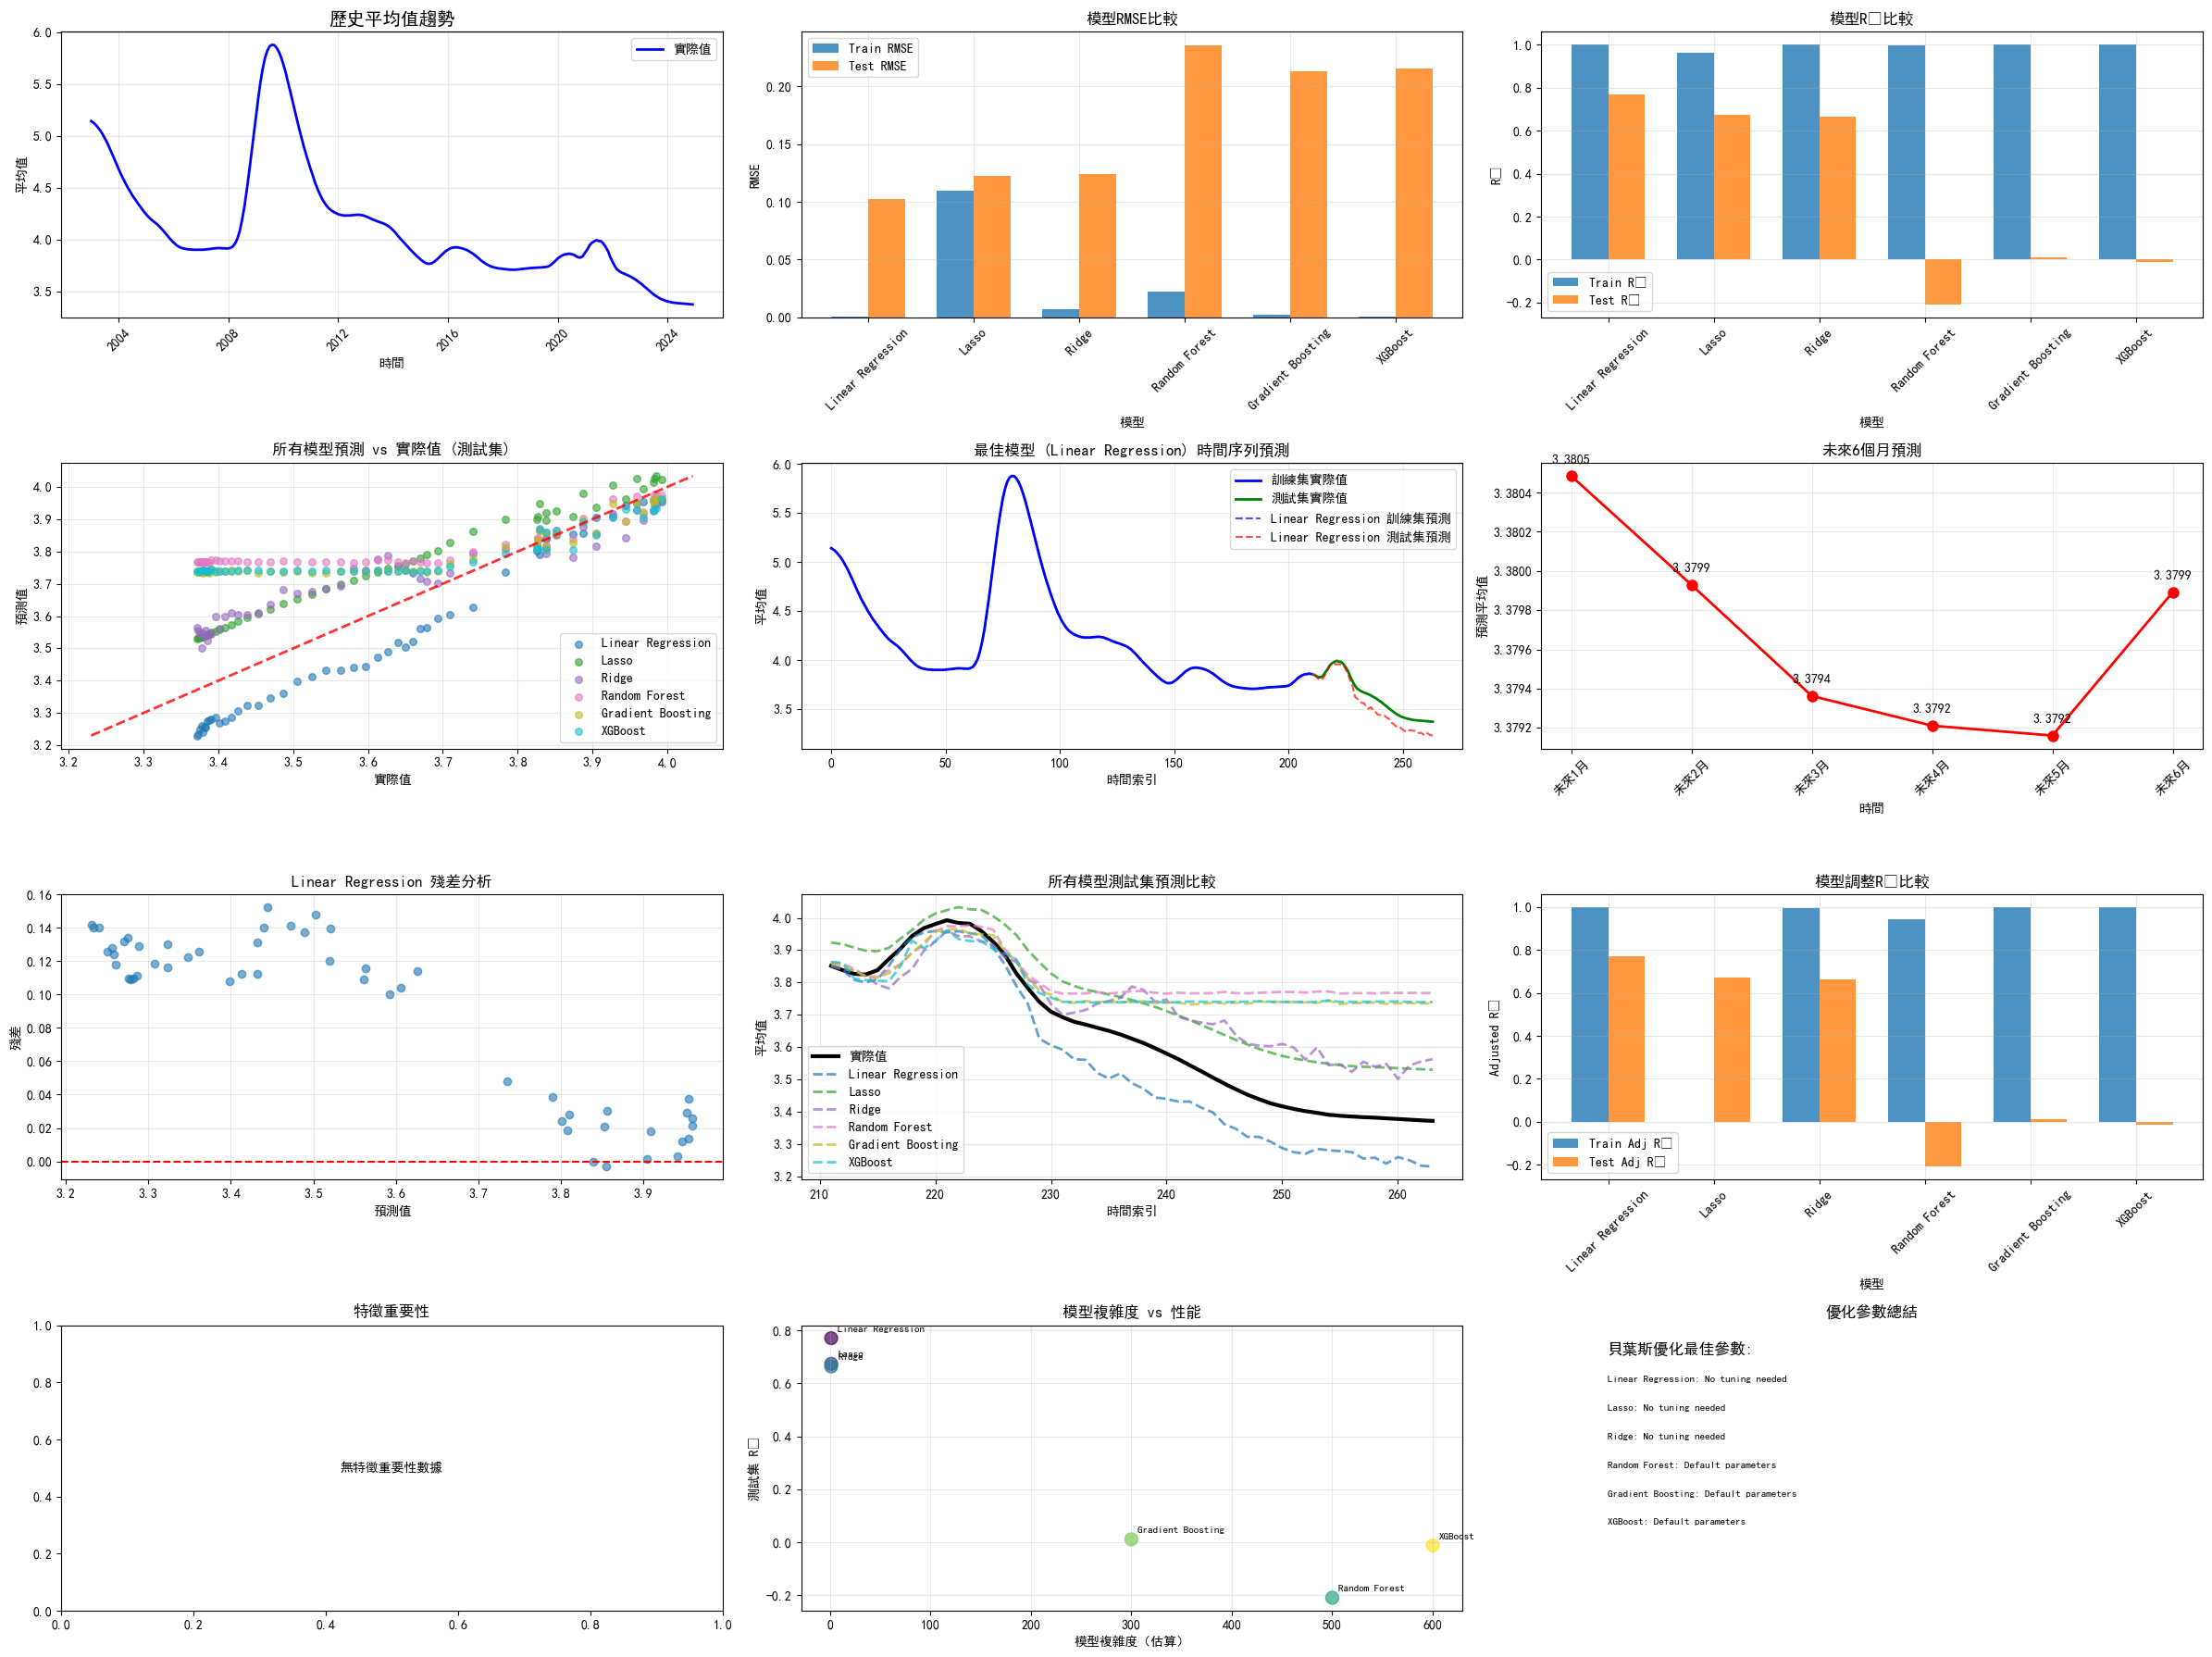

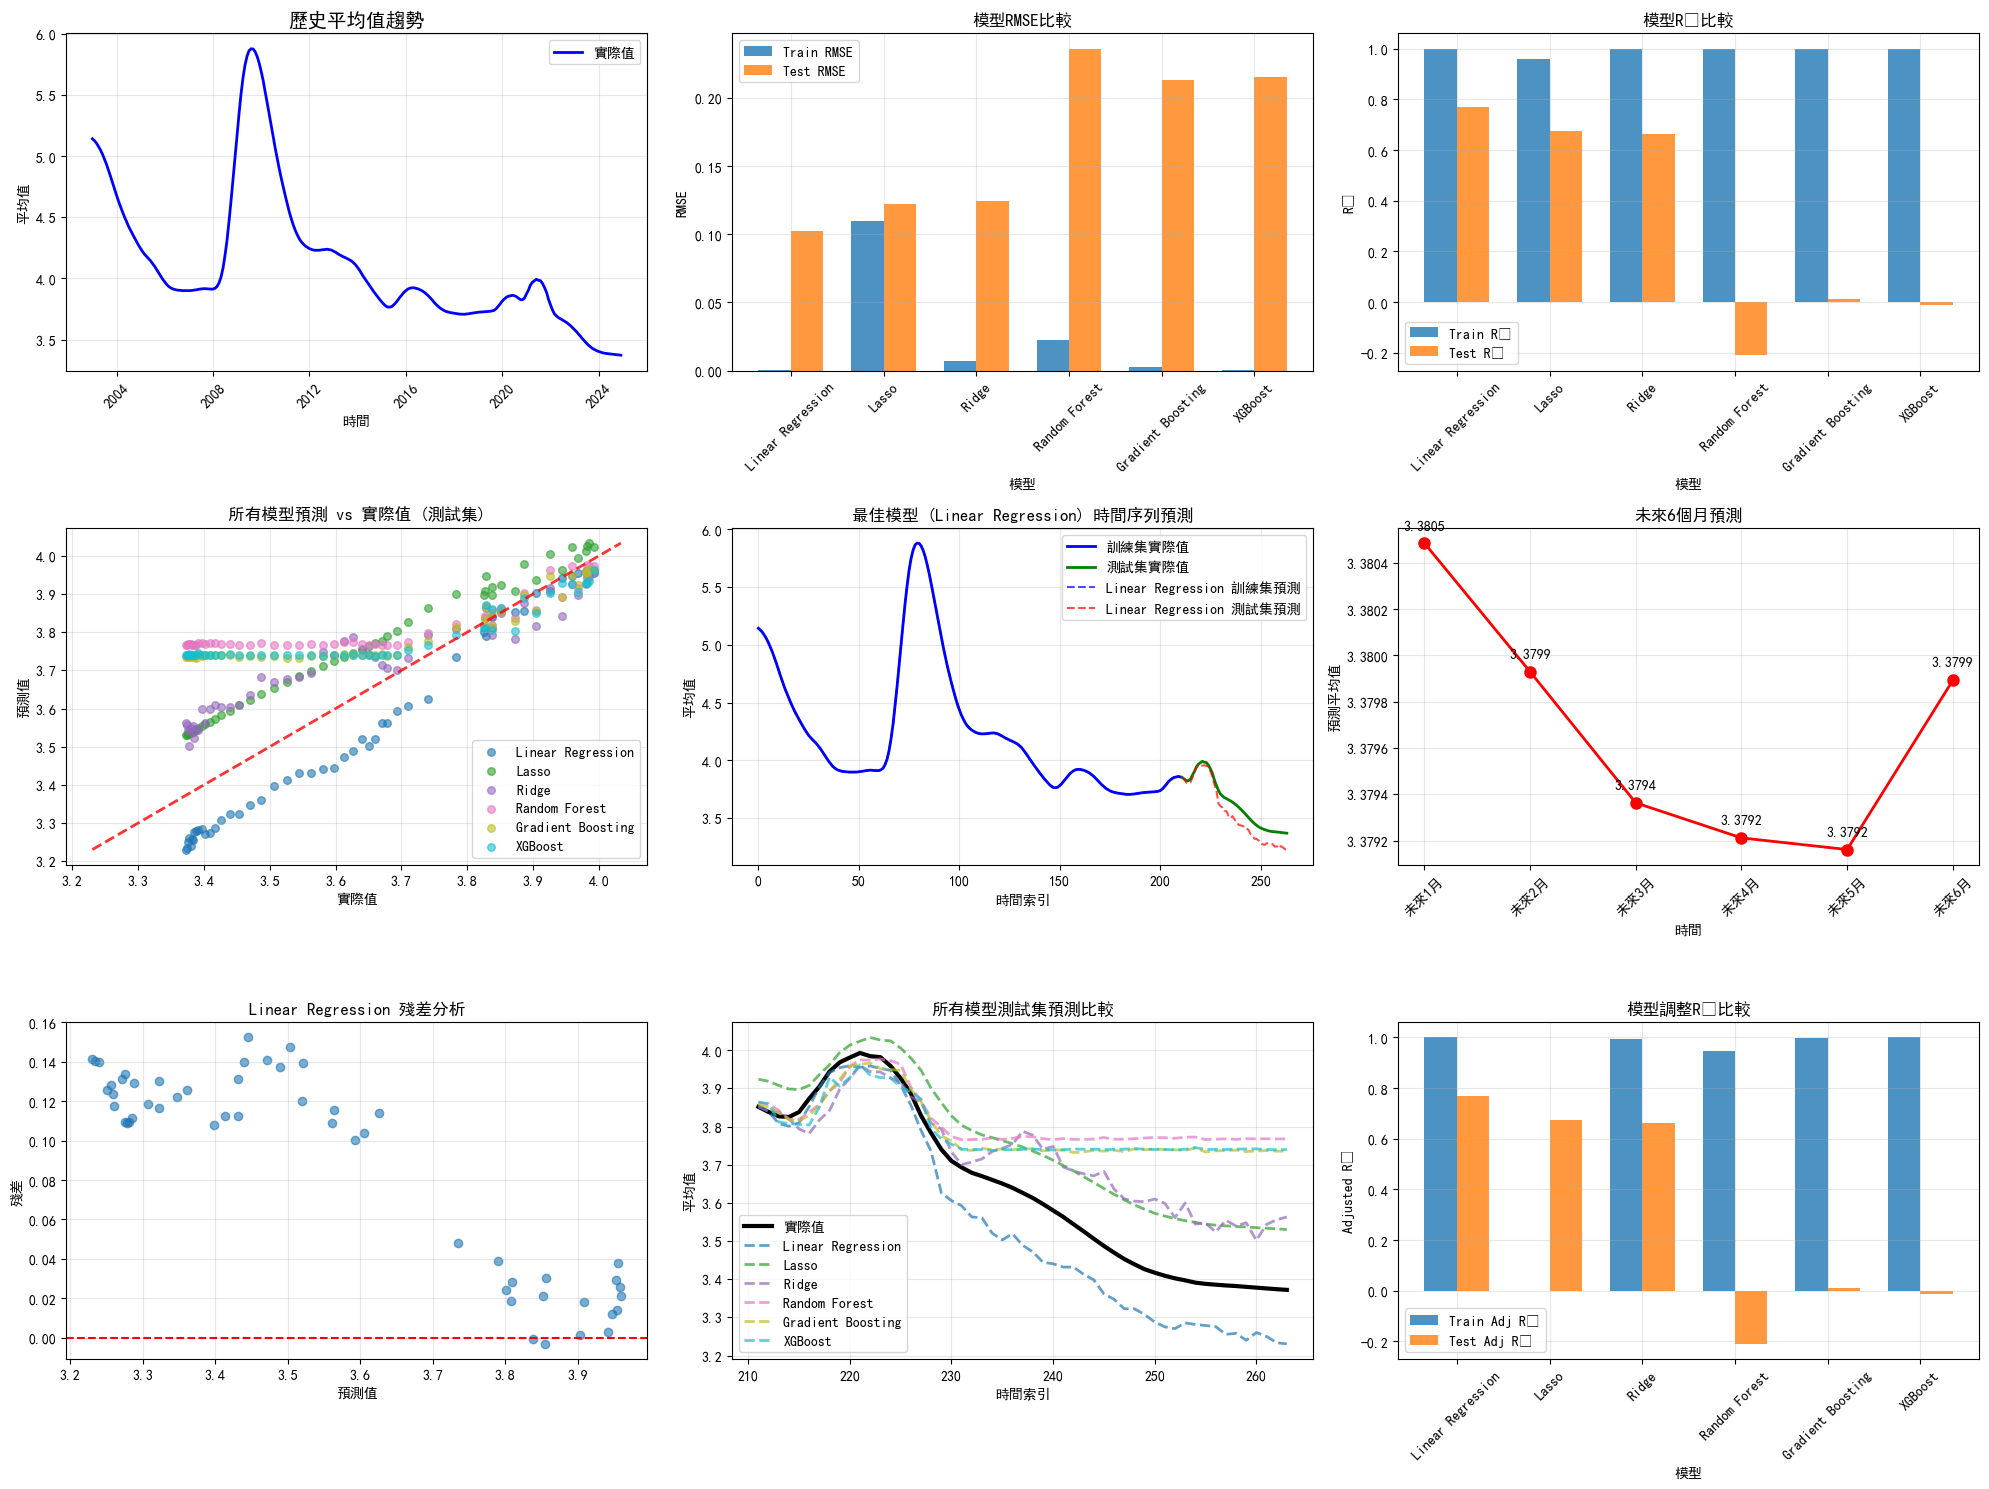

   綜合圖表生成完成

=== 預測完成 ===


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 嘗試導入XGBoost和貝葉斯優化，如果沒有安裝則跳過
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("警告：XGBoost未安裝，將跳過XGBoost模型")

try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args
    from skopt.acquisition import gaussian_ei
    BAYESIAN_OPT_AVAILABLE = True
except ImportError:
    BAYESIAN_OPT_AVAILABLE = False
    print("警告：scikit-optimize未安裝，將跳過貝葉斯優化")

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 讀取Excel檔案
def load_data(file_path):
    """
    讀取失業率資料Excel檔案
    """
    df = pd.read_excel(file_path, sheet_name=0)
    return df

# 數據預處理
def preprocess_data(df):
    """
    數據預處理和特徵工程
    """
    data = df.copy()
    
    # 處理時間欄位
    if '統計期' in data.columns:
        def convert_roc_to_ad(roc_date):
            try:
                year_month = roc_date.replace('年', '-').replace('月', '')
                year, month = year_month.split('-')
                ad_year = int(year) + 1911
                return f"{ad_year}-{month.zfill(2)}"
            except:
                return None
        
        data['年月'] = data['統計期'].apply(convert_roc_to_ad)
        data['年月'] = pd.to_datetime(data['年月'], format='%Y-%m')
        data = data.sort_values('年月').reset_index(drop=True)
    
    # 處理缺失值
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].fillna(method='ffill')
    data[numeric_columns] = data[numeric_columns].fillna(method='bfill')
    
    # 移除非數值欄位
    feature_columns = [col for col in data.columns if col not in ['統計期', '年月', '平均']]
    feature_columns = [col for col in feature_columns if data[col].dtype in ['int64', 'float64']]
    
    return data, feature_columns

# 創建時間序列特徵（使用前一時間點預測下一時間點）
def create_time_series_features(data, target_col='平均', feature_cols=None):
    """
    創建時間序列特徵，使用t-1時間點的所有特徵預測t時間點的目標值
    """
    df = data.copy()
    
    if feature_cols is None:
        feature_cols = [col for col in df.columns 
                       if col not in ['統計期', '年月', target_col] and 
                       df[col].dtype in ['int64', 'float64']]
    
    # 創建滯後特徵（t-1時間點的所有特徵）
    lagged_features = []
    for col in feature_cols:
        df[f'{col}_lag1'] = df[col].shift(1)
        lagged_features.append(f'{col}_lag1')
    
    # 創建目標變數的滯後特徵
    for lag in [1, 2, 3, 6, 12]:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        lagged_features.append(f'{target_col}_lag_{lag}')
    
    # 創建移動平均特徵
    for window in [3, 6, 12]:
        df[f'{target_col}_ma_{window}'] = df[target_col].shift(1).rolling(window=window).mean()
        lagged_features.append(f'{target_col}_ma_{window}')
    
    # 創建趨勢特徵
    df[f'{target_col}_trend'] = df[target_col].shift(1).rolling(window=6).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 6 else np.nan
    )
    lagged_features.append(f'{target_col}_trend')
    
    # 創建季節性特徵
    if '年月' in df.columns:
        df['月份'] = df['年月'].dt.month
        df['季度'] = df['年月'].dt.quarter
        df['年份'] = df['年月'].dt.year
        df['月份_sin'] = np.sin(2 * np.pi * df['月份'] / 12)
        df['月份_cos'] = np.cos(2 * np.pi * df['月份'] / 12)
        lagged_features.extend(['月份', '季度', '月份_sin', '月份_cos'])
    
    # 移除包含NaN的行
    df_clean = df.dropna()
    
    return df_clean, lagged_features

# 貝葉斯優化參數調整
def bayesian_optimize_model(model_type, X_train, y_train, X_val, y_val, n_calls=50):
    """
    使用貝葉斯優化進行超參數調整
    """
    if not BAYESIAN_OPT_AVAILABLE:
        print(f"   跳過 {model_type} 的貝葉斯優化（scikit-optimize未安裝）")
        return None
    
    print(f"   開始 {model_type} 的貝葉斯優化...")
    
    # 定義搜索空間
    if model_type == 'Random Forest':
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 20, name='max_depth'),
            Integer(2, 20, name='min_samples_split'),
            Integer(1, 10, name='min_samples_leaf'),
            Real(0.1, 1.0, name='max_features')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = RandomForestRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    elif model_type == 'Gradient Boosting':
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 10, name='max_depth'),
            Real(0.01, 0.3, name='learning_rate'),
            Real(0.1, 1.0, name='subsample'),
            Integer(2, 20, name='min_samples_split'),
            Integer(1, 10, name='min_samples_leaf')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = GradientBoostingRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    elif model_type == 'XGBoost' and XGBOOST_AVAILABLE:
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 10, name='max_depth'),
            Real(0.01, 0.3, name='learning_rate'),
            Real(0.1, 1.0, name='subsample'),
            Real(0.1, 1.0, name='colsample_bytree'),
            Real(0, 10, name='reg_alpha'),
            Real(0, 10, name='reg_lambda')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = xgb.XGBRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    else:
        return None
    
    # 執行貝葉斯優化
    try:
        result = gp_minimize(
            func=objective,
            dimensions=dimensions,
            n_calls=n_calls,
            random_state=42,
            acquisition_func=gaussian_ei
        )
        
        # 返回最佳參數
        best_params = {}
        for i, dim in enumerate(dimensions):
            best_params[dim.name] = result.x[i]
        
        print(f"   {model_type} 最佳參數: {best_params}")
        print(f"   最佳MSE: {result.fun:.6f}")
        
        return best_params
    
    except Exception as e:
        print(f"   {model_type} 貝葉斯優化失敗: {e}")
        return None
    """
    計算調整R²
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adjusted_r2

# 計算調整R²
def adjusted_r2_score(y_true, y_pred, n_features):
    """
    計算調整R²
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adjusted_r2

# 模型訓練和評估（包含貝葉斯優化）
def train_models_with_optimization(X_train, X_test, y_train, y_test, use_bayesian_opt=True):
    """
    訓練多個機器學習模型，包含貝葉斯優化
    """
    # 從訓練集中分出驗證集用於超參數優化
    if use_bayesian_opt and BAYESIAN_OPT_AVAILABLE:
        X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, shuffle=False
        )
        print(f"   優化用訓練集: {len(X_train_opt)}, 驗證集: {len(X_val_opt)}")
    else:
        X_train_opt, X_val_opt = X_train, None
        y_train_opt, y_val_opt = y_train, None
    
    # 基礎模型（不進行貝葉斯優化）
    base_models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(alpha=0.1, random_state=42),
        'Ridge': Ridge(alpha=1.0, random_state=42)
    }
    
    # 需要優化的樹模型
    tree_models = ['Random Forest', 'Gradient Boosting']
    if XGBOOST_AVAILABLE:
        tree_models.append('XGBoost')
    
    results = {}
    trained_models = {}
    scalers = {}
    best_params = {}
    
    # 訓練基礎模型
    for name, model in base_models.items():
        print(f"   訓練 {name}...")
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        scalers[name] = scaler
        
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # 計算指標
        results[name] = calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, X_train.shape[1])
        trained_models[name] = model
        best_params[name] = "No tuning needed"
    
    # 訓練樹模型（使用貝葉斯優化）
    for model_type in tree_models:
        print(f"   訓練 {model_type}...")
        scalers[model_type] = None
        
        # 貝葉斯優化
        if use_bayesian_opt and BAYESIAN_OPT_AVAILABLE and X_val_opt is not None:
            optimized_params = bayesian_optimize_model(
                model_type, X_train_opt, y_train_opt, X_val_opt, y_val_opt, n_calls=30
            )
        else:
            optimized_params = None
        
        # 創建模型
        if model_type == 'Random Forest':
            if optimized_params:
                model = RandomForestRegressor(random_state=42, **optimized_params)
            else:
                model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        elif model_type == 'Gradient Boosting':
            if optimized_params:
                model = GradientBoostingRegressor(random_state=42, **optimized_params)
            else:
                model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        
        elif model_type == 'XGBoost':
            if optimized_params:
                model = xgb.XGBRegressor(random_state=42, **optimized_params)
            else:
                model = xgb.XGBRegressor(n_estimators=100, random_state=42)
        
        # 訓練最終模型
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # 計算指標
        results[model_type] = calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, X_train.shape[1])
        trained_models[model_type] = model
        best_params[model_type] = optimized_params if optimized_params else "Default parameters"
    
    return results, trained_models, scalers, best_params

def calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, n_features):
    """
    計算所有評估指標
    """
    # 訓練集指標
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 修正Adjusted R²計算，避免異常值
    n_train = len(y_train)
    if n_train > n_features + 1 and train_r2 >= 0:
        train_adj_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - n_features - 1)
        train_adj_r2 = max(0, min(1, train_adj_r2))  # 限制在[0,1]範圍內
    else:
        train_adj_r2 = train_r2
    
    # 測試集指標
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 修正Adjusted R²計算
    n_test = len(y_test)
    if n_test > n_features + 1 and test_r2 >= 0:
        test_adj_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - n_features - 1)
        test_adj_r2 = max(0, min(1, test_adj_r2))  # 限制在[0,1]範圍內
    else:
        test_adj_r2 = test_r2
    
    return {
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'train_adj_r2': train_adj_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_adj_r2': test_adj_r2,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred
    }

# Voting Ensemble 功能
def create_voting_ensemble(results, trained_models, scalers, X_train, X_test, y_train, y_test, enhanced_data, feature_columns):
    """
    創建Lasso和Linear Regression的Voting Ensemble
    """
    print("\n   創建 Lasso + Linear Regression Voting Ensemble...")
    
    # 檢查模型是否存在
    if 'Lasso' not in trained_models or 'Linear Regression' not in trained_models:
        print("   錯誤：Lasso或Linear Regression模型不存在")
        return None, None
    
    # 獲取模型和標準化器
    lasso_model = trained_models['Lasso']
    lr_model = trained_models['Linear Regression']
    lasso_scaler = scalers['Lasso']
    lr_scaler = scalers['Linear Regression']
    
    # 標準化數據
    X_train_lasso = lasso_scaler.transform(X_train)
    X_test_lasso = lasso_scaler.transform(X_test)
    X_train_lr = lr_scaler.transform(X_train)
    X_test_lr = lr_scaler.transform(X_test)
    
    # 獲取各模型的預測
    lasso_train_pred = lasso_model.predict(X_train_lasso)
    lasso_test_pred = lasso_model.predict(X_test_lasso)
    lr_train_pred = lr_model.predict(X_train_lr)
    lr_test_pred = lr_model.predict(X_test_lr)
    
    # Voting Ensemble (簡單平均)
    voting_train_pred = (lasso_train_pred + lr_train_pred) / 2
    voting_test_pred = (lasso_test_pred + lr_test_pred) / 2
    
    # 計算Voting Ensemble的性能指標
    voting_metrics = calculate_metrics(y_train, voting_train_pred, y_test, voting_test_pred, X_train.shape[1])
    
    print(f"   Voting Ensemble 性能:")
    print(f"     Train RMSE: {voting_metrics['train_rmse']:.4f}")
    print(f"     Test RMSE: {voting_metrics['test_rmse']:.4f}")
    print(f"     Train R²: {voting_metrics['train_r2']:.4f}")
    print(f"     Test R²: {voting_metrics['test_r2']:.4f}")
    
    # 預測未來值
    future_predictions_voting = predict_future_voting_ensemble(
        lasso_model, lr_model, lasso_scaler, lr_scaler, 
        enhanced_data, feature_columns, months_ahead=6
    )
    
    return voting_metrics, future_predictions_voting

def predict_future_voting_ensemble(lasso_model, lr_model, lasso_scaler, lr_scaler, data, feature_cols, months_ahead=6):
    """
    使用Voting Ensemble預測未來值
    """
    predictions = []
    df_copy = data.copy()
    
    # 獲取歷史統計信息
    historical_values = df_copy['平均'].values
    mean_historical = historical_values.mean()
    
    for i in range(months_ahead):
        try:
            # 使用最近的數據作為特徵
            recent_data = df_copy.tail(1).copy()
            
            if len(feature_cols) > 0:
                X_latest = recent_data[feature_cols].values.reshape(1, -1)
                X_latest = np.nan_to_num(X_latest, nan=mean_historical)
                
                # 確保特徵維度匹配
                if X_latest.shape[1] != lasso_scaler.n_features_in_:
                    if X_latest.shape[1] > lasso_scaler.n_features_in_:
                        X_latest = X_latest[:, :lasso_scaler.n_features_in_]
                    else:
                        padding = np.full((1, lasso_scaler.n_features_in_ - X_latest.shape[1]), mean_historical)
                        X_latest = np.concatenate([X_latest, padding], axis=1)
                
                # 標準化並預測
                X_lasso = lasso_scaler.transform(X_latest)
                X_lr = lr_scaler.transform(X_latest)
                
                lasso_pred = lasso_model.predict(X_lasso)[0]
                lr_pred = lr_model.predict(X_lr)[0]
                
                # Voting (平均)
                pred = (lasso_pred + lr_pred) / 2
                
                # 約束預測結果
                min_historical = historical_values.min()
                max_historical = historical_values.max()
                std_historical = historical_values.std()
                recent_trend = historical_values[-6:].mean() if len(historical_values) >= 6 else mean_historical
                
                lower_bound = min(min_historical, recent_trend - 2 * std_historical)
                upper_bound = max(max_historical, recent_trend + 2 * std_historical)
                pred = np.clip(pred, lower_bound, upper_bound)
            else:
                pred = mean_historical
            
            predictions.append(pred)
            
            # 更新數據框
            new_row = recent_data.copy()
            new_row['平均'] = pred
            
            # 更新時間相關特徵
            if '月份' in new_row.columns:
                current_month = new_row['月份'].iloc[0]
                next_month = (current_month % 12) + 1
                new_row['月份'] = next_month
                new_row['季度'] = ((next_month - 1) // 3) + 1
                if '月份_sin' in new_row.columns:
                    new_row['月份_sin'] = np.sin(2 * np.pi * next_month / 12)
                if '月份_cos' in new_row.columns:
                    new_row['月份_cos'] = np.cos(2 * np.pi * next_month / 12)
            
            df_copy = pd.concat([df_copy, new_row], ignore_index=True)
            
        except Exception as e:
            print(f"   Voting預測第{i+1}個月時發生錯誤: {e}")
            if len(predictions) > 0:
                pred = predictions[-1]
            else:
                pred = mean_historical
            predictions.append(pred)
    
    return predictions

def save_results_to_csv(results, trained_models, scalers, X_train, X_test, y_train, y_test, 
                       enhanced_data, feature_columns, voting_metrics, future_predictions_voting, 
                       filename='unemployment_prediction_results.csv'):
    """
    將所有結果保存到CSV檔案
    """
    print(f"\n   保存結果到 {filename}...")
    
    try:
        # 創建結果數據框
        results_data = []
        
        # 1. 添加歷史數據和所有模型的預測
        train_size = len(X_train)
        test_size = len(X_test)
        
        # 重建時間索引
        if '年月' in enhanced_data.columns:
            time_column = enhanced_data['年月'].iloc[-(train_size + test_size):].reset_index(drop=True)
        else:
            time_column = pd.date_range(start='2002-01', periods=train_size + test_size, freq='M')
        
        # 合併實際值
        actual_values = pd.concat([y_train.reset_index(drop=True), y_test.reset_index(drop=True)])
        
        # 為每個時間點創建記錄
        for i in range(len(actual_values)):
            row = {
                '時間': time_column.iloc[i] if i < len(time_column) else None,
                '實際值': actual_values.iloc[i],
                '數據集': 'Train' if i < train_size else 'Test'
            }
            
            # 添加所有模型的預測
            for model_name in results.keys():
                if i < train_size:
                    row[f'{model_name}_預測'] = results[model_name]['train_predictions'][i]
                else:
                    test_idx = i - train_size
                    row[f'{model_name}_預測'] = results[model_name]['test_predictions'][test_idx]
            
            # 添加Voting Ensemble預測
            if voting_metrics:
                if i < train_size:
                    row['Voting_Ensemble_預測'] = voting_metrics['train_predictions'][i]
                else:
                    test_idx = i - train_size
                    row['Voting_Ensemble_預測'] = voting_metrics['test_predictions'][test_idx]
            
            results_data.append(row)
        
        # 2. 添加未來預測
        if future_predictions_voting:
            last_date = time_column.iloc[-1] if len(time_column) > 0 else pd.Timestamp('2024-12-01')
            
            for i, pred_value in enumerate(future_predictions_voting, 1):
                future_date = last_date + pd.DateOffset(months=i)
                row = {
                    '時間': future_date,
                    '實際值': None,
                    '數據集': 'Future'
                }
                
                # 為其他模型添加空值
                for model_name in results.keys():
                    row[f'{model_name}_預測'] = None
                
                # 添加Voting Ensemble的未來預測
                row['Voting_Ensemble_預測'] = pred_value
                
                results_data.append(row)
        
        # 創建DataFrame並保存
        results_df = pd.DataFrame(results_data)
        results_df.to_csv(filename, index=False, encoding='utf-8-sig')
        
        print(f"   成功保存 {len(results_df)} 筆記錄到 {filename}")
        
        # 創建模型性能摘要CSV
        performance_filename = filename.replace('.csv', '_performance.csv')
        performance_data = []
        
        for model_name, metrics in results.items():
            performance_data.append({
                '模型': model_name,
                'Train_RMSE': metrics['train_rmse'],
                'Test_RMSE': metrics['test_rmse'],
                'Train_MAE': metrics['train_mae'],
                'Test_MAE': metrics['test_mae'],
                'Train_R2': metrics['train_r2'],
                'Test_R2': metrics['test_r2'],
                'Train_Adj_R2': max(-1, min(1, metrics['train_adj_r2'])),
                'Test_Adj_R2': max(-1, min(1, metrics['test_adj_r2']))
            })
        
        # 添加Voting Ensemble性能
        if voting_metrics:
            performance_data.append({
                '模型': 'Voting_Ensemble',
                'Train_RMSE': voting_metrics['train_rmse'],
                'Test_RMSE': voting_metrics['test_rmse'],
                'Train_MAE': voting_metrics['train_mae'],
                'Test_MAE': voting_metrics['test_mae'],
                'Train_R2': voting_metrics['train_r2'],
                'Test_R2': voting_metrics['test_r2'],
                'Train_Adj_R2': max(-1, min(1, voting_metrics['train_adj_r2'])),
                'Test_Adj_R2': max(-1, min(1, voting_metrics['test_adj_r2']))
            })
        
        performance_df = pd.DataFrame(performance_data)
        performance_df.to_csv(performance_filename, index=False, encoding='utf-8-sig')
        
        print(f"   成功保存模型性能到 {performance_filename}")
        
        return results_df, performance_df
        
    except Exception as e:
        print(f"   保存CSV時發生錯誤: {e}")
        import traceback
        traceback.print_exc()
        return None, None
def predict_future_improved(model, scaler, data, feature_cols, target_col='平均', months_ahead=6, model_name='Random Forest'):
    """
    使用改進的滾動預測方法預測未來值，確保預測結果在合理範圍內
    """
    predictions = []
    df_copy = data.copy()
    
    # 獲取歷史目標值的統計信息，用於約束預測結果
    historical_values = df_copy[target_col].values
    min_historical = historical_values.min()
    max_historical = historical_values.max()
    mean_historical = historical_values.mean()
    std_historical = historical_values.std()
    
    print(f"   歷史數據範圍: [{min_historical:.4f}, {max_historical:.4f}]")
    print(f"   歷史數據均值: {mean_historical:.4f}, 標準差: {std_historical:.4f}")
    
    for i in range(months_ahead):
        try:
            # 使用最近的數據作為特徵
            recent_data = df_copy.tail(1).copy()
            
            # 構建特徵向量 - 使用更簡單的方法
            if len(feature_cols) > 0:
                # 使用最後一行的所有特徵
                X_latest = recent_data[feature_cols].values.reshape(1, -1)
                
                # 處理NaN值
                X_latest = np.nan_to_num(X_latest, nan=mean_historical)
                
                # 進行預測
                if model_name in ['Linear Regression', 'Lasso', 'Ridge'] and scaler is not None:
                    # 確保特徵維度匹配
                    if X_latest.shape[1] != scaler.n_features_in_:
                        # 調整維度
                        if X_latest.shape[1] > scaler.n_features_in_:
                            X_latest = X_latest[:, :scaler.n_features_in_]
                        else:
                            # 用均值填充
                            padding = np.full((1, scaler.n_features_in_ - X_latest.shape[1]), mean_historical)
                            X_latest = np.concatenate([X_latest, padding], axis=1)
                    
                    X_scaled = scaler.transform(X_latest)
                    pred = model.predict(X_scaled)[0]
                else:
                    pred = model.predict(X_latest)[0]
                
                # 約束預測結果在合理範圍內
                # 使用最近趨勢和歷史範圍來約束
                recent_trend = historical_values[-6:].mean() if len(historical_values) >= 6 else mean_historical
                
                # 限制預測值不要偏離歷史範圍太遠
                lower_bound = min(min_historical, recent_trend - 2 * std_historical)
                upper_bound = max(max_historical, recent_trend + 2 * std_historical)
                
                pred = np.clip(pred, lower_bound, upper_bound)
                
            else:
                # 如果沒有特徵，使用簡單的趨勢預測
                if len(historical_values) >= 3:
                    pred = np.mean(historical_values[-3:])
                else:
                    pred = mean_historical
            
            predictions.append(pred)
            
            # 更新數據框
            new_row = recent_data.copy()
            new_row[target_col] = pred
            
            # 更新時間相關特徵
            if '月份' in new_row.columns:
                current_month = new_row['月份'].iloc[0]
                next_month = (current_month % 12) + 1
                new_row['月份'] = next_month
                new_row['季度'] = ((next_month - 1) // 3) + 1
                if '月份_sin' in new_row.columns:
                    new_row['月份_sin'] = np.sin(2 * np.pi * next_month / 12)
                if '月份_cos' in new_row.columns:
                    new_row['月份_cos'] = np.cos(2 * np.pi * next_month / 12)
            
            df_copy = pd.concat([df_copy, new_row], ignore_index=True)
            
        except Exception as e:
            print(f"   預測第{i+1}個月時發生錯誤: {e}")
            # 使用簡單的備用預測
            if len(predictions) > 0:
                pred = predictions[-1]  # 使用上一個預測值
            else:
                pred = mean_historical  # 使用歷史均值
            predictions.append(pred)
    
    return predictions

# 可視化結果（包含優化參數資訊）
def plot_comprehensive_results_with_optimization(data, results, trained_models, scalers, best_params, X_train, X_test, y_train, y_test, future_predictions=None):
    """
    綜合視覺化結果，包含優化參數資訊
    """
    fig = plt.figure(figsize=(24, 18))
    
    # 1. 歷史數據趨勢
    plt.subplot(4, 3, 1)
    if '年月' in data.columns:
        plt.plot(data['年月'], data['平均'], 'b-', linewidth=2, label='實際值')
        plt.title('歷史平均值趨勢', fontsize=14)
        plt.xlabel('時間')
        plt.ylabel('平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    # 2. 模型性能比較 - RMSE
    plt.subplot(4, 3, 2)
    model_names = list(results.keys())
    train_rmse = [results[model]['train_rmse'] for model in model_names]
    test_rmse = [results[model]['test_rmse'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
    plt.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('RMSE')
    plt.title('模型RMSE比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 模型性能比較 - R²
    plt.subplot(4, 3, 3)
    train_r2 = [results[model]['train_r2'] for model in model_names]
    test_r2 = [results[model]['test_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
    plt.bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('R²')
    plt.title('模型R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 所有模型預測vs實際值（測試集）
    plt.subplot(4, 3, 4)
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    
    for i, model_name in enumerate(model_names):
        test_pred = results[model_name]['test_predictions']
        plt.scatter(y_test, test_pred, alpha=0.6, label=model_name, color=colors[i], s=30)
    
    # 添加完美預測線
    min_val = min(y_test.min(), min([results[model]['test_predictions'].min() for model in model_names]))
    max_val = max(y_test.max(), max([results[model]['test_predictions'].max() for model in model_names]))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
    
    plt.xlabel('實際值')
    plt.ylabel('預測值')
    plt.title('所有模型預測 vs 實際值 (測試集)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. 時間序列預測結果
    plt.subplot(4, 3, 5)
    train_size = len(X_train)
    test_size = len(X_test)
    
    best_model = min(results.keys(), key=lambda x: results[x]['test_rmse'])
    
    train_indices = range(train_size)
    test_indices = range(train_size, train_size + test_size)
    
    plt.plot(train_indices, y_train, 'b-', label='訓練集實際值', linewidth=2)
    plt.plot(test_indices, y_test, 'g-', label='測試集實際值', linewidth=2)
    plt.plot(train_indices, results[best_model]['train_predictions'], 'b--', 
             label=f'{best_model} 訓練集預測', alpha=0.7)
    plt.plot(test_indices, results[best_model]['test_predictions'], 'r--', 
             label=f'{best_model} 測試集預測', alpha=0.7)
    
    plt.title(f'最佳模型 ({best_model}) 時間序列預測')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. 未來預測
    if future_predictions:
        plt.subplot(4, 3, 6)
        future_months = ['未來' + str(i+1) + '月' for i in range(len(future_predictions))]
        plt.plot(future_months, future_predictions, 'ro-', linewidth=2, markersize=8)
        plt.title('未來6個月預測')
        plt.xlabel('時間')
        plt.ylabel('預測平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for i, v in enumerate(future_predictions):
            plt.annotate(f'{v:.4f}', (i, v), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    # 7. 殘差分析
    plt.subplot(4, 3, 7)
    test_pred = results[best_model]['test_predictions']
    residuals = y_test - test_pred
    plt.scatter(test_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('預測值')
    plt.ylabel('殘差')
    plt.title(f'{best_model} 殘差分析')
    plt.grid(True, alpha=0.3)
    
    # 8. 所有模型在測試集上的時間序列比較
    plt.subplot(4, 3, 8)
    plt.plot(test_indices, y_test, 'k-', label='實際值', linewidth=3)
    
    for i, model_name in enumerate(model_names):
        test_pred = results[model_name]['test_predictions']
        plt.plot(test_indices, test_pred, '--', alpha=0.7, 
                label=f'{model_name}', color=colors[i], linewidth=2)
    
    plt.title('所有模型測試集預測比較')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. 調整R²比較
    plt.subplot(4, 3, 9)
    train_adj_r2 = [results[model]['train_adj_r2'] for model in model_names]
    test_adj_r2 = [results[model]['test_adj_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_adj_r2, width, label='Train Adj R²', alpha=0.8)
    plt.bar(x + width/2, test_adj_r2, width, label='Test Adj R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('Adjusted R²')
    plt.title('模型調整R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 10. 優化參數熱力圖（針對樹模型）
    plt.subplot(4, 3, 10)
    tree_models = ['Random Forest', 'Gradient Boosting']
    if XGBOOST_AVAILABLE:
        tree_models.append('XGBoost')
    
    param_importance = []
    tree_model_names = []
    
    for model_name in tree_models:
        if model_name in best_params and isinstance(best_params[model_name], dict):
            tree_model_names.append(model_name)
            # 獲取特徵重要性
            if hasattr(trained_models[model_name], 'feature_importances_'):
                importances = trained_models[model_name].feature_importances_
                top_10_importance = sorted(importances, reverse=True)[:10]
                param_importance.append(top_10_importance)
    
    if param_importance:
        param_importance = np.array(param_importance)
        im = plt.imshow(param_importance, cmap='viridis', aspect='auto')
        plt.colorbar(im)
        plt.yticks(range(len(tree_model_names)), tree_model_names)
        plt.xlabel('Top 10 特徵重要性排名')
        plt.title('樹模型特徵重要性熱力圖')
    else:
        plt.text(0.5, 0.5, '無特徵重要性數據', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('特徵重要性')
    
    # 11. 模型複雜度 vs 性能
    plt.subplot(4, 3, 11)
    model_complexity = []
    test_scores = []
    
    for model_name in model_names:
        test_scores.append(results[model_name]['test_r2'])
        
        # 估算模型複雜度
        if model_name in ['Linear Regression', 'Lasso', 'Ridge']:
            complexity = 1  # 線性模型複雜度低
        elif model_name == 'Random Forest':
            if isinstance(best_params[model_name], dict):
                complexity = best_params[model_name].get('n_estimators', 100) * best_params[model_name].get('max_depth', 5)
            else:
                complexity = 500  # 默認估值
        elif model_name == 'Gradient Boosting':
            if isinstance(best_params[model_name], dict):
                complexity = best_params[model_name].get('n_estimators', 100) * best_params[model_name].get('max_depth', 3)
            else:
                complexity = 300  # 默認估值
        elif model_name == 'XGBoost':
            if isinstance(best_params[model_name], dict):
                complexity = best_params[model_name].get('n_estimators', 100) * best_params[model_name].get('max_depth', 6)
            else:
                complexity = 600  # 默認估值
        else:
            complexity = 100
        
        model_complexity.append(complexity)
    
    scatter = plt.scatter(model_complexity, test_scores, c=range(len(model_names)), 
                         cmap='viridis', s=100, alpha=0.7)
    
    for i, model_name in enumerate(model_names):
        plt.annotate(model_name, (model_complexity[i], test_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.xlabel('模型複雜度（估算）')
    plt.ylabel('測試集 R²')
    plt.title('模型複雜度 vs 性能')
    plt.grid(True, alpha=0.3)
    
    # 12. 優化歷程（如果有的話）
    plt.subplot(4, 3, 12)
    plt.text(0.1, 0.9, '貝葉斯優化最佳參數:', fontsize=12, weight='bold', transform=plt.gca().transAxes)
    
    y_pos = 0.8
    for model_name, params in best_params.items():
        if isinstance(params, dict):
            param_str = f"{model_name}:\n"
            for key, value in params.items():
                if isinstance(value, float):
                    param_str += f"  {key}: {value:.4f}\n"
                else:
                    param_str += f"  {key}: {value}\n"
            plt.text(0.1, y_pos, param_str, fontsize=8, transform=plt.gca().transAxes)
            y_pos -= 0.25
        else:
            plt.text(0.1, y_pos, f"{model_name}: {params}", fontsize=8, transform=plt.gca().transAxes)
            y_pos -= 0.1
    
    plt.axis('off')
    plt.title('優化參數總結')
    
    plt.tight_layout()
    plt.show()
    """
    綜合視覺化結果
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. 歷史數據趨勢
    plt.subplot(3, 3, 1)
    if '年月' in data.columns:
        plt.plot(data['年月'], data['平均'], 'b-', linewidth=2, label='實際值')
        plt.title('歷史平均值趨勢', fontsize=14)
        plt.xlabel('時間')
        plt.ylabel('平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    # 2. 模型性能比較 - RMSE
    plt.subplot(3, 3, 2)
    model_names = list(results.keys())
    train_rmse = [results[model]['train_rmse'] for model in model_names]
    test_rmse = [results[model]['test_rmse'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
    plt.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('RMSE')
    plt.title('模型RMSE比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 模型性能比較 - R²
    plt.subplot(3, 3, 3)
    train_r2 = [results[model]['train_r2'] for model in model_names]
    test_r2 = [results[model]['test_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
    plt.bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('R²')
    plt.title('模型R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 所有模型預測vs實際值（測試集）
    plt.subplot(3, 3, 4)
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    
    for i, model_name in enumerate(model_names):
        test_pred = results[model_name]['test_predictions']
        plt.scatter(y_test, test_pred, alpha=0.6, label=model_name, color=colors[i], s=30)
    
    # 添加完美預測線
    min_val = min(y_test.min(), min([results[model]['test_predictions'].min() for model in model_names]))
    max_val = max(y_test.max(), max([results[model]['test_predictions'].max() for model in model_names]))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
    
    plt.xlabel('實際值')
    plt.ylabel('預測值')
    plt.title('所有模型預測 vs 實際值 (測試集)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. 時間序列預測結果
    plt.subplot(3, 3, 5)
    # 重建完整的時間軸
    train_size = len(X_train)
    test_size = len(X_test)
    
    # 取最佳模型（基於測試集RMSE）
    best_model = min(results.keys(), key=lambda x: results[x]['test_rmse'])
    
    train_indices = range(train_size)
    test_indices = range(train_size, train_size + test_size)
    
    plt.plot(train_indices, y_train, 'b-', label='訓練集實際值', linewidth=2)
    plt.plot(test_indices, y_test, 'g-', label='測試集實際值', linewidth=2)
    plt.plot(train_indices, results[best_model]['train_predictions'], 'b--', 
             label=f'{best_model} 訓練集預測', alpha=0.7)
    plt.plot(test_indices, results[best_model]['test_predictions'], 'r--', 
             label=f'{best_model} 測試集預測', alpha=0.7)
    
    plt.title(f'最佳模型 ({best_model}) 時間序列預測')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. 未來預測
    if future_predictions:
        plt.subplot(3, 3, 6)
        future_months = ['未來' + str(i+1) + '月' for i in range(len(future_predictions))]
        plt.plot(future_months, future_predictions, 'ro-', linewidth=2, markersize=8)
        plt.title('未來6個月預測')
        plt.xlabel('時間')
        plt.ylabel('預測平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for i, v in enumerate(future_predictions):
            plt.annotate(f'{v:.4f}', (i, v), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    # 7. 殘差分析
    plt.subplot(3, 3, 7)
    test_pred = results[best_model]['test_predictions']
    residuals = y_test - test_pred
    plt.scatter(test_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('預測值')
    plt.ylabel('殘差')
    plt.title(f'{best_model} 殘差分析')
    plt.grid(True, alpha=0.3)
    
    # 8. 所有模型在測試集上的時間序列比較
    plt.subplot(3, 3, 8)
    plt.plot(test_indices, y_test, 'k-', label='實際值', linewidth=3)
    
    for i, model_name in enumerate(model_names):
        test_pred = results[model_name]['test_predictions']
        plt.plot(test_indices, test_pred, '--', alpha=0.7, 
                label=f'{model_name}', color=colors[i], linewidth=2)
    
    plt.title('所有模型測試集預測比較')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. 調整R²比較
    plt.subplot(3, 3, 9)
    train_adj_r2 = [results[model]['train_adj_r2'] for model in model_names]
    test_adj_r2 = [results[model]['test_adj_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_adj_r2, width, label='Train Adj R²', alpha=0.8)
    plt.bar(x + width/2, test_adj_r2, width, label='Test Adj R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('Adjusted R²')
    plt.title('模型調整R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 主函數
def main(file_path='失業率資料_2.xlsx'):
    """
    主函數：執行完整的預測流程
    """
    print("=== 改進版失業率平均值預測系統 ===\n")
    
    # 1. 讀取數據
    print("1. 讀取數據...")
    try:
        df = load_data(file_path)
        print(f"   數據載入成功，共 {len(df)} 行 {len(df.columns)} 列")
    except Exception as e:
        print(f"   錯誤：無法讀取檔案 - {e}")
        return
    
    # 2. 數據預處理
    print("\n2. 數據預處理...")
    try:
        processed_data, original_feature_columns = preprocess_data(df)
        print(f"   預處理完成，原始特徵數量：{len(original_feature_columns)}")
    except Exception as e:
        print(f"   錯誤：數據預處理失敗 - {e}")
        return
    
    # 3. 時間序列特徵工程
    print("\n3. 時間序列特徵工程...")
    try:
        enhanced_data, feature_columns = create_time_series_features(
            processed_data, target_col='平均', feature_cols=original_feature_columns
        )
        print(f"   特徵工程完成，最終特徵數量：{len(feature_columns)}")
        print(f"   數據行數：{len(enhanced_data)}")
    except Exception as e:
        print(f"   錯誤：特徵工程失敗 - {e}")
        return
    
    # 4. 準備訓練數據
    print("\n4. 準備訓練數據...")
    try:
        X = enhanced_data[feature_columns]
        y = enhanced_data['平均']
        
        # 時間序列分割：前80%作為訓練集，後20%作為測試集
        split_idx = int(len(X) * 0.8)
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]
        
        print(f"   訓練集大小：{len(X_train)}")
        print(f"   測試集大小：{len(X_test)}")
        print(f"   特徵數量：{len(feature_columns)}")
    except Exception as e:
        print(f"   錯誤：數據準備失敗 - {e}")
        return
    
    # 5. 訓練模型（使用貝葉斯優化）
    print("\n5. 訓練模型（包含貝葉斯優化）...")
    try:
        results, trained_models, scalers, best_params = train_models_with_optimization(
            X_train, X_test, y_train, y_test, use_bayesian_opt=True
        )
        
        print("\n   詳細模型性能比較：")
        print("   " + "="*140)
        print(f"   {'模型':<15} {'Train RMSE':<12} {'Test RMSE':<12} {'Train MAE':<11} {'Test MAE':<11} {'Train R²':<10} {'Test R²':<10} {'Train Adj R²':<13} {'Test Adj R²':<13}")
        print("   " + "="*140)
        
        for model_name, metrics in results.items():
            # 修正Adjusted R²的顯示，確保在合理範圍內
            train_adj_r2 = max(-1, min(1, metrics['train_adj_r2']))
            test_adj_r2 = max(-1, min(1, metrics['test_adj_r2']))
            
            print(f"   {model_name:<15} {metrics['train_rmse']:<12.4f} {metrics['test_rmse']:<12.4f} "
                  f"{metrics['train_mae']:<11.4f} {metrics['test_mae']:<11.4f} "
                  f"{metrics['train_r2']:<10.4f} {metrics['test_r2']:<10.4f} "
                  f"{train_adj_r2:<13.4f} {test_adj_r2:<13.4f}")
        
        # 顯示優化參數
        print("\n   貝葉斯優化結果：")
        print("   " + "="*60)
        for model_name, params in best_params.items():
            if isinstance(params, dict):
                print(f"   {model_name}:")
                for key, value in params.items():
                    if isinstance(value, float):
                        print(f"     {key}: {value:.4f}")
                    else:
                        print(f"     {key}: {value}")
            else:
                print(f"   {model_name}: {params}")
        
    except Exception as e:
        print(f"   錯誤：模型訓練失敗 - {e}")
        return
    
    # 6. 創建Voting Ensemble
    print("\n6. 創建Voting Ensemble...")
    try:
        voting_metrics, future_predictions_voting = create_voting_ensemble(
            results, trained_models, scalers, X_train, X_test, y_train, y_test, 
            enhanced_data, feature_columns
        )
    except Exception as e:
        print(f"   錯誤：Voting Ensemble創建失敗 - {e}")
        voting_metrics, future_predictions_voting = None, None

    # 7. 選擇最佳模型並預測未來
    print("\n7. 預測未來值...")
    try:
        best_model_name = min(results.keys(), key=lambda x: results[x]['test_rmse'])
        best_model = trained_models[best_model_name]
        best_scaler = scalers[best_model_name]
        
        print(f"   最佳模型（基於測試集RMSE）：{best_model_name}")
        
        future_predictions = predict_future_improved(
            best_model, best_scaler, enhanced_data, feature_columns,
            target_col='平均', months_ahead=6, model_name=best_model_name
        )
        
        print("\n   最佳模型未來6個月預測結果：")
        print("   " + "="*40)
        for i, pred in enumerate(future_predictions, 1):
            print(f"   未來第 {i} 月：{pred:.4f}")
        
        if future_predictions_voting:
            print("\n   Voting Ensemble未來6個月預測結果：")
            print("   " + "="*40)
            for i, pred in enumerate(future_predictions_voting, 1):
                print(f"   未來第 {i} 月：{pred:.4f}")
            
    except Exception as e:
        print(f"   錯誤：未來預測失敗 - {e}")
        future_predictions = None

    # 8. 保存結果到CSV
    print("\n8. 保存結果到CSV檔案...")
    try:
        results_df, performance_df = save_results_to_csv(
            results, trained_models, scalers, X_train, X_test, y_train, y_test,
            enhanced_data, feature_columns, voting_metrics, future_predictions_voting
        )
    except Exception as e:
        print(f"   警告：CSV保存失敗 - {e}")
        results_df, performance_df = None, None

    # 9. 生成綜合視覺化
    print("\n9. 生成綜合視覺化圖表...")
    try:
        plot_comprehensive_results_with_optimization(
            enhanced_data, results, trained_models, scalers, best_params,
            X_train, X_test, y_train, y_test, future_predictions_voting or future_predictions
        )
        print("   綜合圖表生成完成")
    except Exception as e:
        print(f"   警告：圖表生成失敗 - {e}")
        import traceback
        traceback.print_exc()
    
    print("\n=== 預測完成 ===")
    
    return {
        'results': results,
        'models': trained_models,
        'scalers': scalers,
        'future_predictions': future_predictions,
        'voting_metrics': voting_metrics,
        'future_predictions_voting': future_predictions_voting,
        'results_df': results_df,
        'performance_df': performance_df,
        'best_params': best_params,
        'best_model': best_model_name,
        'enhanced_data': enhanced_data,
        'feature_columns': feature_columns
    }

# 執行預測
if __name__ == "__main__":
    # 安裝所需套件的提示
    print("請確保已安裝以下套件：")
    print("pip install pandas numpy scikit-learn matplotlib seaborn openpyxl scikit-optimize")
    if XGBOOST_AVAILABLE:
        print("XGBoost 已安裝")
    else:
        print("如需使用XGBoost，請執行：pip install xgboost")
    
    if BAYESIAN_OPT_AVAILABLE:
        print("scikit-optimize 已安裝，將使用貝葉斯優化")
    else:
        print("如需使用貝葉斯優化，請執行：pip install scikit-optimize")
    
    print("\n" + "="*50 + "\n")
    
    prediction_results = main('失業率資料_2.xlsx')

請確保已安裝以下套件：
pip install pandas numpy scikit-learn matplotlib seaborn openpyxl scikit-optimize
XGBoost 已安裝
scikit-optimize 已安裝，將使用貝葉斯優化


=== 改進版失業率平均值預測系統 ===

1. 讀取數據...
   數據載入成功，共 276 行 193 列

2. 數據預處理...
   預處理完成，原始特徵數量：191

3. 時間序列特徵工程...
   特徵工程完成，最終特徵數量：204
   數據行數：264

4. 準備訓練數據...
   訓練集大小：211
   測試集大小：53
   特徵數量：204

5. 訓練模型（包含貝葉斯優化）...
   優化用訓練集: 168, 驗證集: 43
   訓練 Linear Regression...
   訓練 Lasso...
   訓練 Ridge...
   訓練 Random Forest...
   開始 Random Forest 的貝葉斯優化...
   Random Forest 貝葉斯優化失敗: gp_minimize() got an unexpected keyword argument 'acquisition_func'
   訓練 Gradient Boosting...
   開始 Gradient Boosting 的貝葉斯優化...
   Gradient Boosting 貝葉斯優化失敗: gp_minimize() got an unexpected keyword argument 'acquisition_func'
   訓練 XGBoost...
   開始 XGBoost 的貝葉斯優化...
   XGBoost 貝葉斯優化失敗: gp_minimize() got an unexpected keyword argument 'acquisition_func'

   詳細模型性能比較：
   模型              Train RMSE   Test RMSE    Train MAE   Test MAE    Train R²   Test R²    Train Adj R²  Test Adj R²  
  

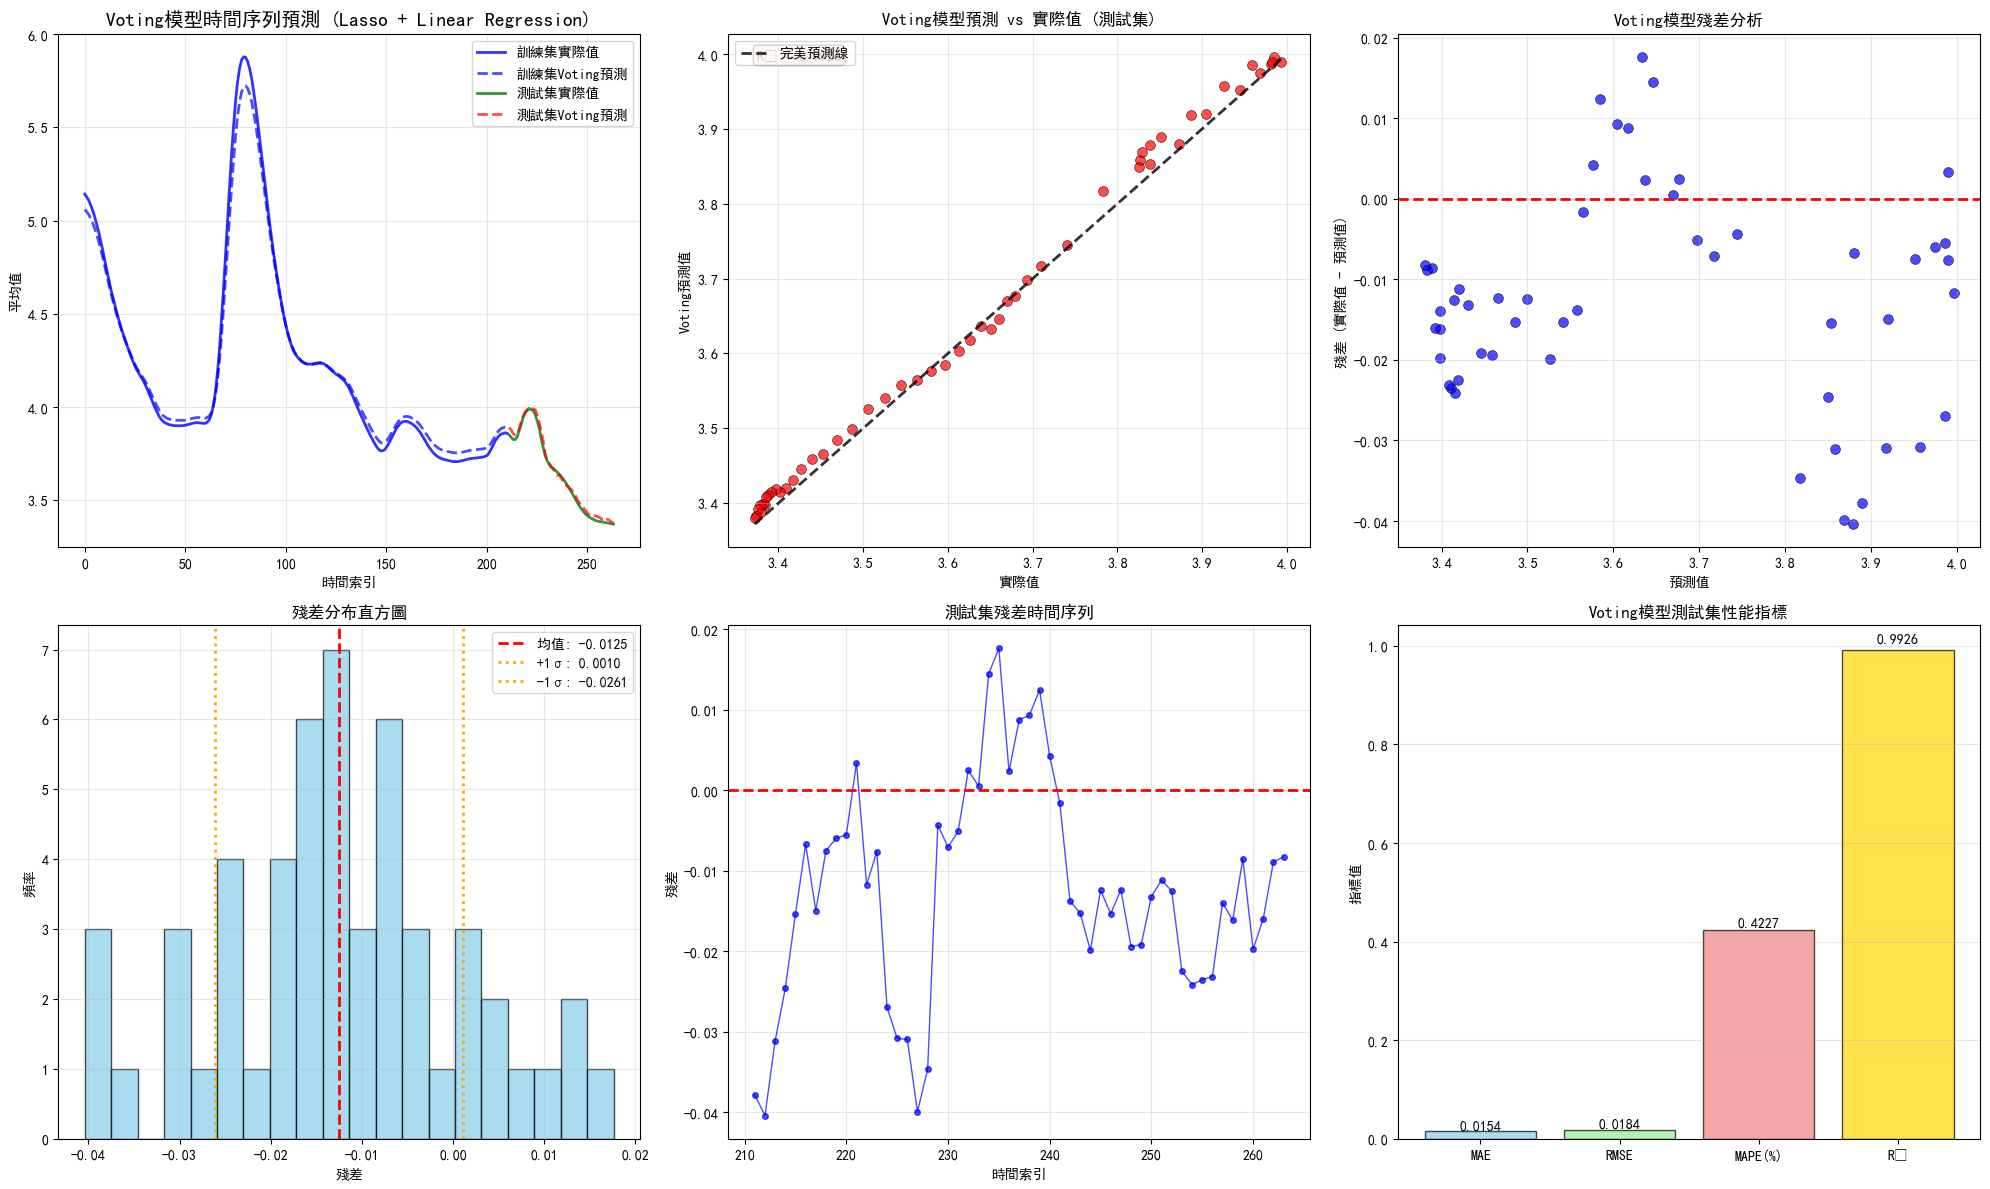


   Voting模型詳細性能統計:
   測試集 MAE:  0.015388
   測試集 RMSE: 0.018387
   測試集 MAPE: 0.4227%
   測試集 R²:   0.992623
   殘差均值:    -0.012540
   殘差標準差:  0.013576
   Voting模型分析圖表生成完成

7. 生成綜合視覺化圖表...


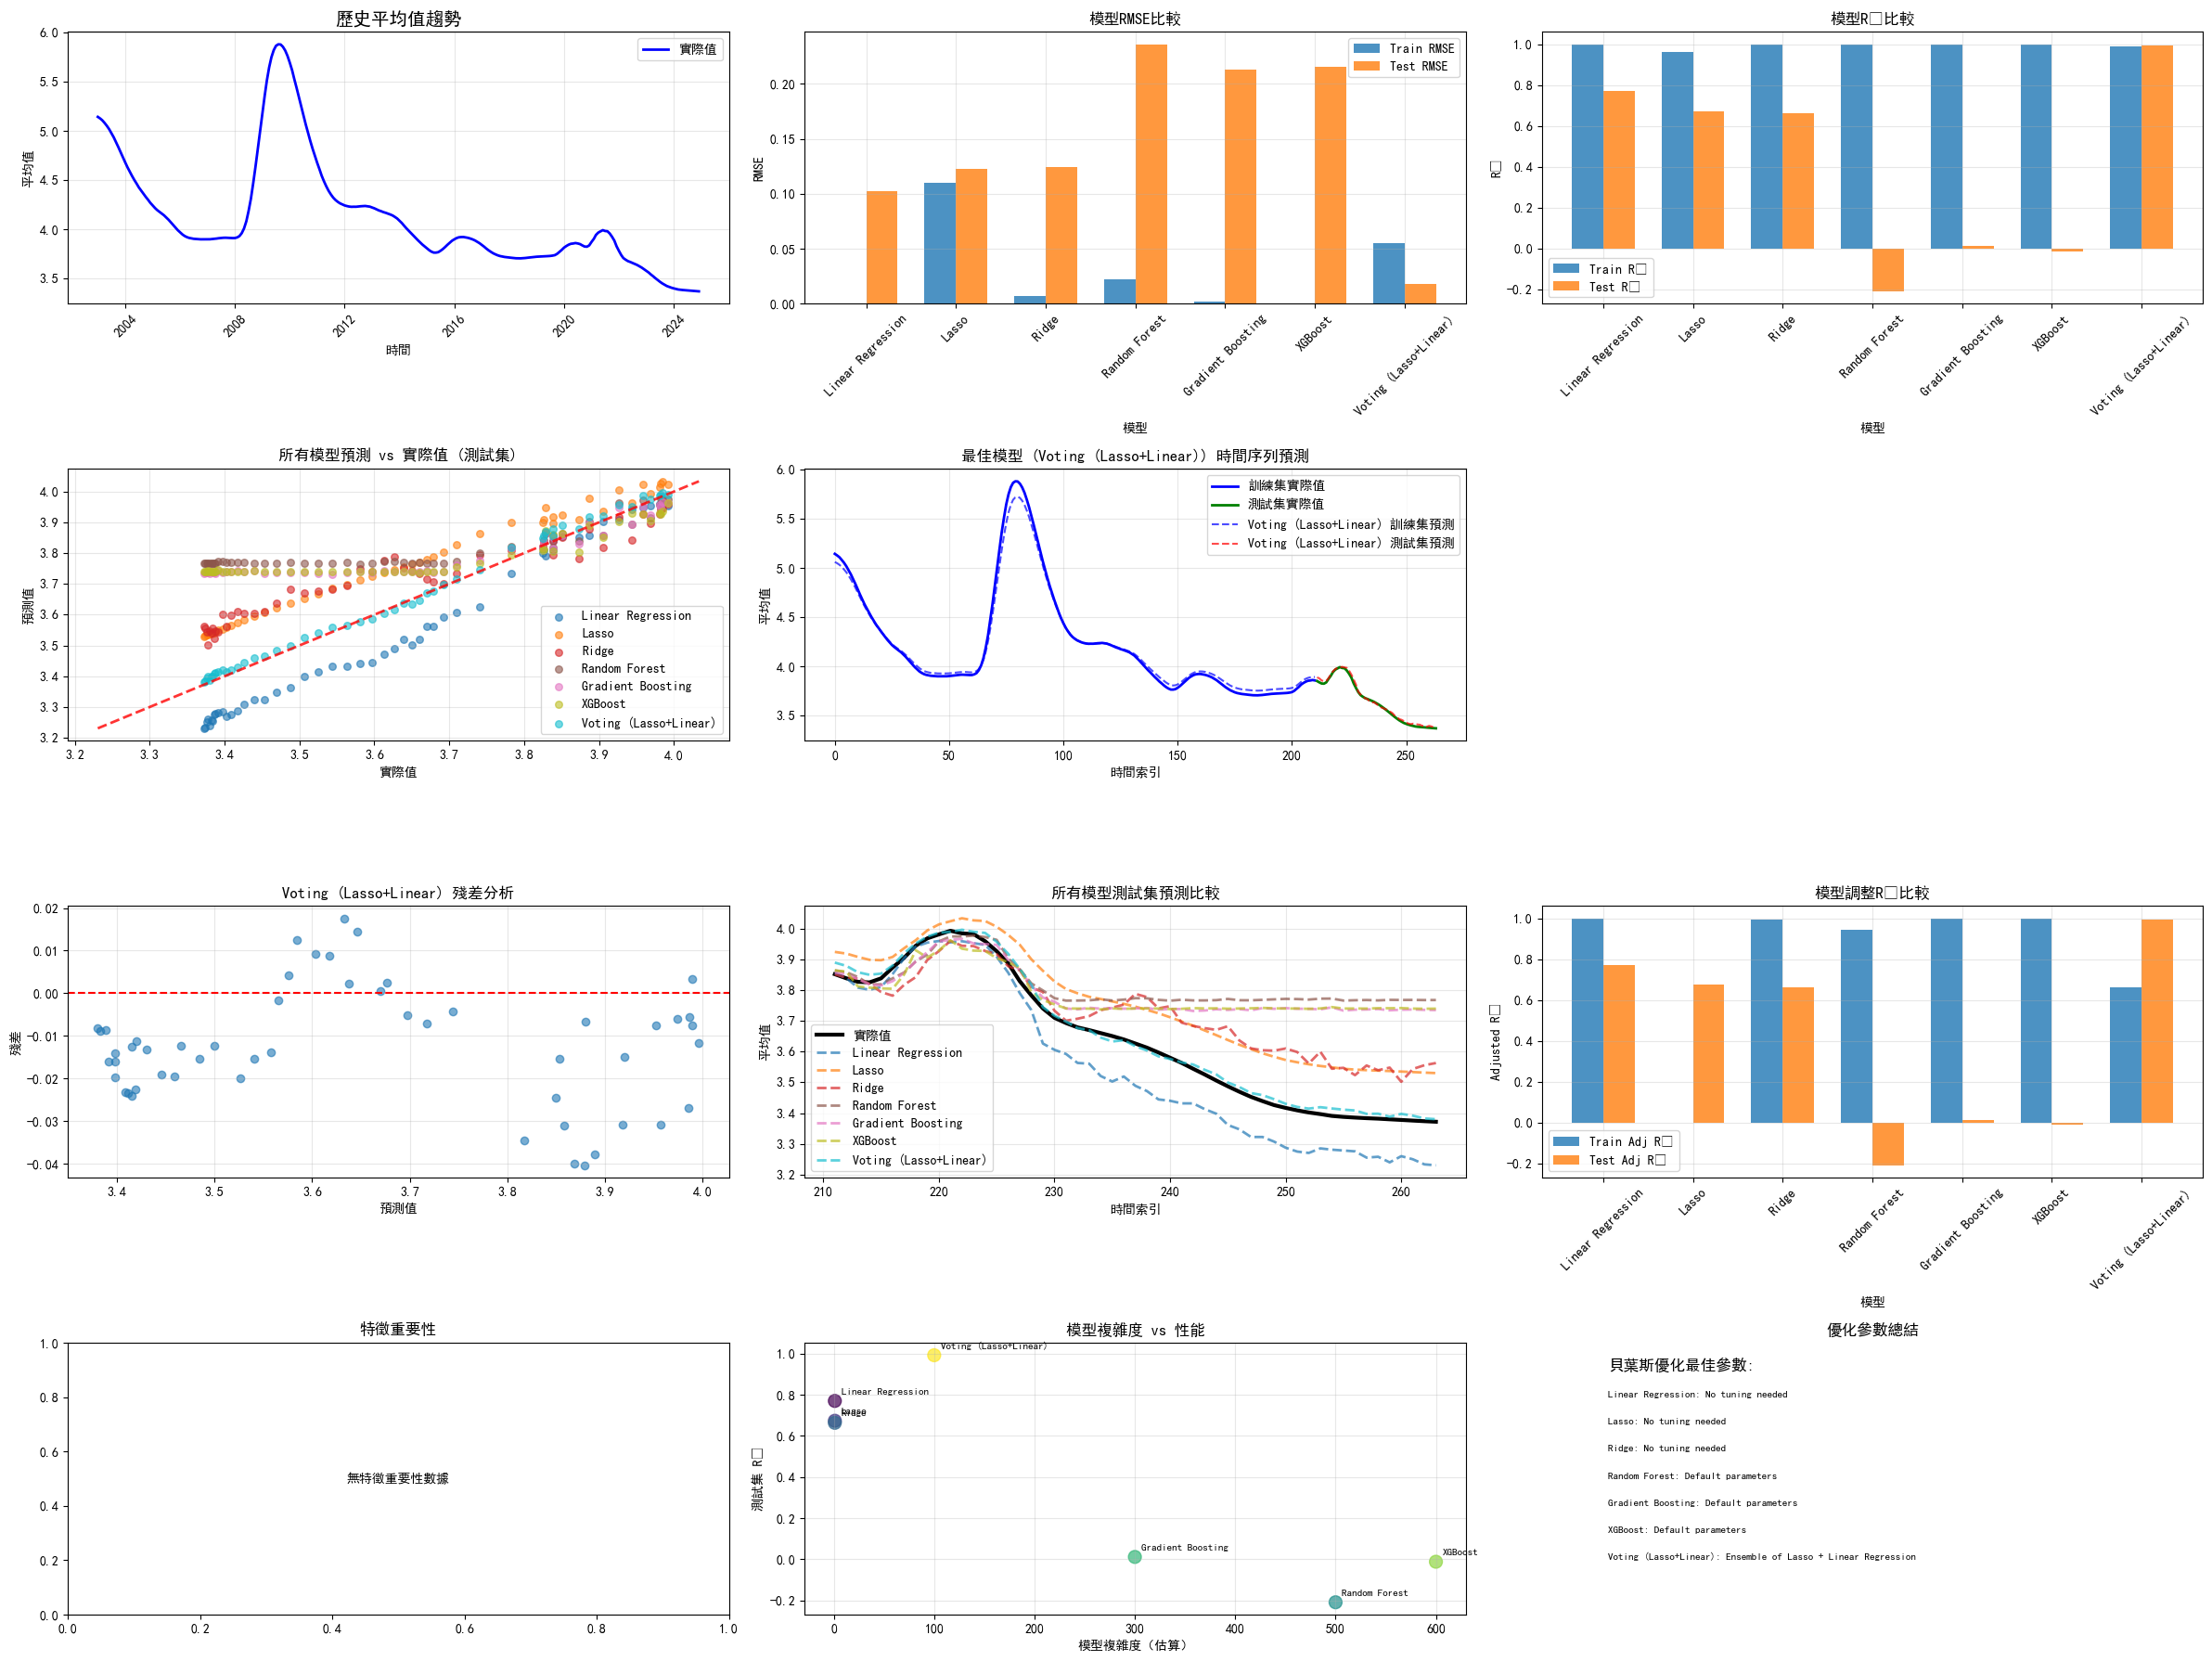

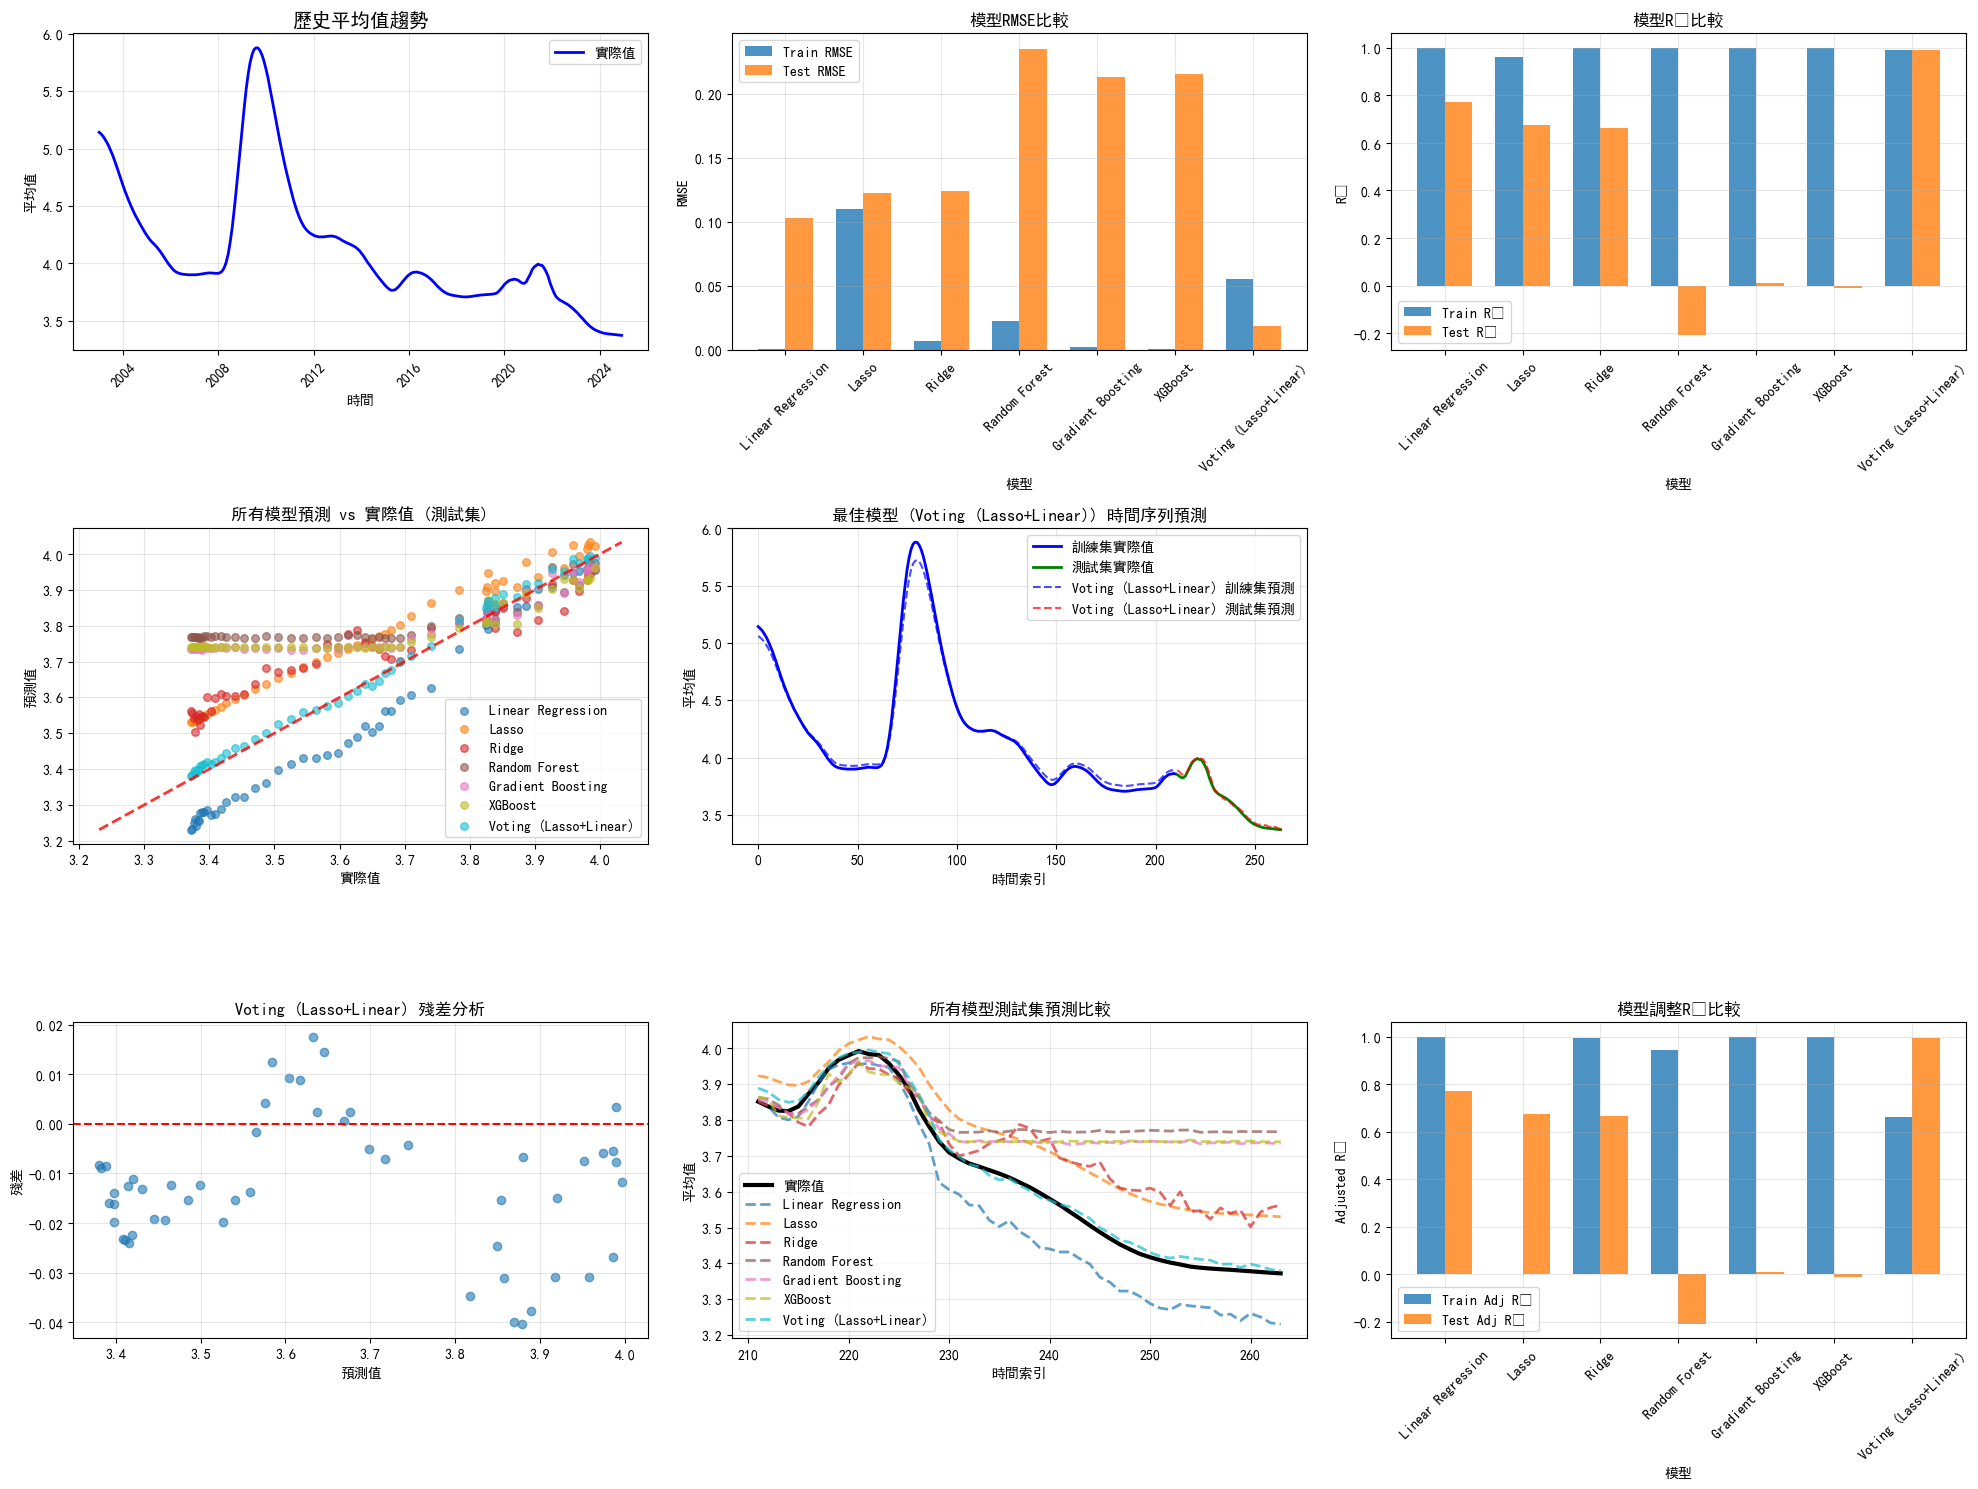

   綜合圖表生成完成

=== 預測完成 ===


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
try:
    from scipy import stats
except ImportError:
    print("警告：scipy未安裝，將跳過部分統計分析功能")

from sklearn.ensemble import VotingRegressor
import csv
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 嘗試導入XGBoost和貝葉斯優化，如果沒有安裝則跳過
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("警告：XGBoost未安裝，將跳過XGBoost模型")

try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args
    from skopt.acquisition import gaussian_ei
    BAYESIAN_OPT_AVAILABLE = True
except ImportError:
    BAYESIAN_OPT_AVAILABLE = False
    print("警告：scikit-optimize未安裝，將跳過貝葉斯優化")

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 讀取Excel檔案
def load_data(file_path):
    """
    讀取失業率資料Excel檔案
    """
    df = pd.read_excel(file_path, sheet_name=0)
    return df

# 數據預處理
def preprocess_data(df):
    """
    數據預處理和特徵工程
    """
    data = df.copy()
    
    # 處理時間欄位
    if '統計期' in data.columns:
        def convert_roc_to_ad(roc_date):
            try:
                year_month = roc_date.replace('年', '-').replace('月', '')
                year, month = year_month.split('-')
                ad_year = int(year) + 1911
                return f"{ad_year}-{month.zfill(2)}"
            except:
                return None
        
        data['年月'] = data['統計期'].apply(convert_roc_to_ad)
        data['年月'] = pd.to_datetime(data['年月'], format='%Y-%m')
        data = data.sort_values('年月').reset_index(drop=True)
    
    # 處理缺失值
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].fillna(method='ffill')
    data[numeric_columns] = data[numeric_columns].fillna(method='bfill')
    
    # 移除非數值欄位
    feature_columns = [col for col in data.columns if col not in ['統計期', '年月', '平均']]
    feature_columns = [col for col in feature_columns if data[col].dtype in ['int64', 'float64']]
    
    return data, feature_columns

# 創建時間序列特徵（使用前一時間點預測下一時間點）
def create_time_series_features(data, target_col='平均', feature_cols=None):
    """
    創建時間序列特徵，使用t-1時間點的所有特徵預測t時間點的目標值
    """
    df = data.copy()
    
    if feature_cols is None:
        feature_cols = [col for col in df.columns 
                       if col not in ['統計期', '年月', target_col] and 
                       df[col].dtype in ['int64', 'float64']]
    
    # 創建滯後特徵（t-1時間點的所有特徵）
    lagged_features = []
    for col in feature_cols:
        df[f'{col}_lag1'] = df[col].shift(1)
        lagged_features.append(f'{col}_lag1')
    
    # 創建目標變數的滯後特徵
    for lag in [1, 2, 3, 6, 12]:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        lagged_features.append(f'{target_col}_lag_{lag}')
    
    # 創建移動平均特徵
    for window in [3, 6, 12]:
        df[f'{target_col}_ma_{window}'] = df[target_col].shift(1).rolling(window=window).mean()
        lagged_features.append(f'{target_col}_ma_{window}')
    
    # 創建趨勢特徵
    df[f'{target_col}_trend'] = df[target_col].shift(1).rolling(window=6).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 6 else np.nan
    )
    lagged_features.append(f'{target_col}_trend')
    
    # 創建季節性特徵
    if '年月' in df.columns:
        df['月份'] = df['年月'].dt.month
        df['季度'] = df['年月'].dt.quarter
        df['年份'] = df['年月'].dt.year
        df['月份_sin'] = np.sin(2 * np.pi * df['月份'] / 12)
        df['月份_cos'] = np.cos(2 * np.pi * df['月份'] / 12)
        lagged_features.extend(['月份', '季度', '月份_sin', '月份_cos'])
    
    # 移除包含NaN的行
    df_clean = df.dropna()
    
    return df_clean, lagged_features

# 貝葉斯優化參數調整
def bayesian_optimize_model(model_type, X_train, y_train, X_val, y_val, n_calls=50):
    """
    使用貝葉斯優化進行超參數調整
    """
    if not BAYESIAN_OPT_AVAILABLE:
        print(f"   跳過 {model_type} 的貝葉斯優化（scikit-optimize未安裝）")
        return None
    
    print(f"   開始 {model_type} 的貝葉斯優化...")
    
    # 定義搜索空間
    if model_type == 'Random Forest':
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 20, name='max_depth'),
            Integer(2, 20, name='min_samples_split'),
            Integer(1, 10, name='min_samples_leaf'),
            Real(0.1, 1.0, name='max_features')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = RandomForestRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    elif model_type == 'Gradient Boosting':
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 10, name='max_depth'),
            Real(0.01, 0.3, name='learning_rate'),
            Real(0.1, 1.0, name='subsample'),
            Integer(2, 20, name='min_samples_split'),
            Integer(1, 10, name='min_samples_leaf')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = GradientBoostingRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    elif model_type == 'XGBoost' and XGBOOST_AVAILABLE:
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 10, name='max_depth'),
            Real(0.01, 0.3, name='learning_rate'),
            Real(0.1, 1.0, name='subsample'),
            Real(0.1, 1.0, name='colsample_bytree'),
            Real(0, 10, name='reg_alpha'),
            Real(0, 10, name='reg_lambda')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = xgb.XGBRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    else:
        return None
    
    # 執行貝葉斯優化
    try:
        result = gp_minimize(
            func=objective,
            dimensions=dimensions,
            n_calls=n_calls,
            random_state=42,
            acquisition_func=gaussian_ei
        )
        
        # 返回最佳參數
        best_params = {}
        for i, dim in enumerate(dimensions):
            best_params[dim.name] = result.x[i]
        
        print(f"   {model_type} 最佳參數: {best_params}")
        print(f"   最佳MSE: {result.fun:.6f}")
        
        return best_params
    
    except Exception as e:
        print(f"   {model_type} 貝葉斯優化失敗: {e}")
        return None
    """
    計算調整R²
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adjusted_r2

# 計算調整R²
def adjusted_r2_score(y_true, y_pred, n_features):
    """
    計算調整R²
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adjusted_r2

# 模型訓練和評估（包含貝葉斯優化）
def train_models_with_optimization(X_train, X_test, y_train, y_test, use_bayesian_opt=True):
    """
    訓練多個機器學習模型，包含貝葉斯優化
    """
    # 從訓練集中分出驗證集用於超參數優化
    if use_bayesian_opt and BAYESIAN_OPT_AVAILABLE:
        X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, shuffle=False
        )
        print(f"   優化用訓練集: {len(X_train_opt)}, 驗證集: {len(X_val_opt)}")
    else:
        X_train_opt, X_val_opt = X_train, None
        y_train_opt, y_val_opt = y_train, None
    
    # 基礎模型（不進行貝葉斯優化）
    base_models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(alpha=0.1, random_state=42),
        'Ridge': Ridge(alpha=1.0, random_state=42)
    }
    
    # 需要優化的樹模型
    tree_models = ['Random Forest', 'Gradient Boosting']
    if XGBOOST_AVAILABLE:
        tree_models.append('XGBoost')
    
    results = {}
    trained_models = {}
    scalers = {}
    best_params = {}
    
    # 訓練基礎模型
    for name, model in base_models.items():
        print(f"   訓練 {name}...")
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        scalers[name] = scaler
        
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # 計算指標
        results[name] = calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, X_train.shape[1])
        trained_models[name] = model
        best_params[name] = "No tuning needed"
    
    # 訓練樹模型（使用貝葉斯優化）
    for model_type in tree_models:
        print(f"   訓練 {model_type}...")
        scalers[model_type] = None
        
        # 貝葉斯優化
        if use_bayesian_opt and BAYESIAN_OPT_AVAILABLE and X_val_opt is not None:
            optimized_params = bayesian_optimize_model(
                model_type, X_train_opt, y_train_opt, X_val_opt, y_val_opt, n_calls=30
            )
        else:
            optimized_params = None
        
        # 創建模型
        if model_type == 'Random Forest':
            if optimized_params:
                model = RandomForestRegressor(random_state=42, **optimized_params)
            else:
                model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        elif model_type == 'Gradient Boosting':
            if optimized_params:
                model = GradientBoostingRegressor(random_state=42, **optimized_params)
            else:
                model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        
        elif model_type == 'XGBoost':
            if optimized_params:
                model = xgb.XGBRegressor(random_state=42, **optimized_params)
            else:
                model = xgb.XGBRegressor(n_estimators=100, random_state=42)
        
        # 訓練最終模型
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # 計算指標
        results[model_type] = calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, X_train.shape[1])
        trained_models[model_type] = model
        best_params[model_type] = optimized_params if optimized_params else "Default parameters"
    
    return results, trained_models, scalers, best_params

def calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, n_features):
    """
    計算所有評估指標
    """
    # 訓練集指標
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 修正Adjusted R²計算，避免異常值
    n_train = len(y_train)
    if n_train > n_features + 1 and train_r2 >= 0:
        train_adj_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - n_features - 1)
        train_adj_r2 = max(0, min(1, train_adj_r2))  # 限制在[0,1]範圍內
    else:
        train_adj_r2 = train_r2
    
    # 測試集指標
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 修正Adjusted R²計算
    n_test = len(y_test)
    if n_test > n_features + 1 and test_r2 >= 0:
        test_adj_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - n_features - 1)
        test_adj_r2 = max(0, min(1, test_adj_r2))  # 限制在[0,1]範圍內
    else:
        test_adj_r2 = test_r2
    
    return {
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'train_adj_r2': train_adj_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_adj_r2': test_adj_r2,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred
    }

# 預測未來值（改進版，確保合理的預測結果）
def predict_future_improved(model, scaler, data, feature_cols, target_col='平均', months_ahead=6, model_name='Random Forest'):
    """
    使用改進的滾動預測方法預測未來值，確保預測結果在合理範圍內
    """
    predictions = []
    df_copy = data.copy()
    
    # 獲取歷史目標值的統計信息，用於約束預測結果
    historical_values = df_copy[target_col].values
    min_historical = historical_values.min()
    max_historical = historical_values.max()
    mean_historical = historical_values.mean()
    std_historical = historical_values.std()
    
    print(f"   歷史數據範圍: [{min_historical:.4f}, {max_historical:.4f}]")
    print(f"   歷史數據均值: {mean_historical:.4f}, 標準差: {std_historical:.4f}")
    
    for i in range(months_ahead):
        try:
            # 使用最近的數據作為特徵
            recent_data = df_copy.tail(1).copy()
            
            # 構建特徵向量 - 使用更簡單的方法
            if len(feature_cols) > 0:
                # 使用最後一行的所有特徵
                X_latest = recent_data[feature_cols].values.reshape(1, -1)
                
                # 處理NaN值
                X_latest = np.nan_to_num(X_latest, nan=mean_historical)
                
                # 進行預測
                if model_name in ['Linear Regression', 'Lasso', 'Ridge'] and scaler is not None:
                    # 確保特徵維度匹配
                    if X_latest.shape[1] != scaler.n_features_in_:
                        # 調整維度
                        if X_latest.shape[1] > scaler.n_features_in_:
                            X_latest = X_latest[:, :scaler.n_features_in_]
                        else:
                            # 用均值填充
                            padding = np.full((1, scaler.n_features_in_ - X_latest.shape[1]), mean_historical)
                            X_latest = np.concatenate([X_latest, padding], axis=1)
                    
                    X_scaled = scaler.transform(X_latest)
                    pred = model.predict(X_scaled)[0]
                else:
                    pred = model.predict(X_latest)[0]
                
                # 約束預測結果在合理範圍內
                # 使用最近趨勢和歷史範圍來約束
                recent_trend = historical_values[-6:].mean() if len(historical_values) >= 6 else mean_historical
                
                # 限制預測值不要偏離歷史範圍太遠
                lower_bound = min(min_historical, recent_trend - 2 * std_historical)
                upper_bound = max(max_historical, recent_trend + 2 * std_historical)
                
                pred = np.clip(pred, lower_bound, upper_bound)
                
            else:
                # 如果沒有特徵，使用簡單的趨勢預測
                if len(historical_values) >= 3:
                    pred = np.mean(historical_values[-3:])
                else:
                    pred = mean_historical
            
            predictions.append(pred)
            
            # 更新數據框
            new_row = recent_data.copy()
            new_row[target_col] = pred
            
            # 更新時間相關特徵
            if '月份' in new_row.columns:
                current_month = new_row['月份'].iloc[0]
                next_month = (current_month % 12) + 1
                new_row['月份'] = next_month
                new_row['季度'] = ((next_month - 1) // 3) + 1
                if '月份_sin' in new_row.columns:
                    new_row['月份_sin'] = np.sin(2 * np.pi * next_month / 12)
                if '月份_cos' in new_row.columns:
                    new_row['月份_cos'] = np.cos(2 * np.pi * next_month / 12)
            
            df_copy = pd.concat([df_copy, new_row], ignore_index=True)
            
        except Exception as e:
            print(f"   預測第{i+1}個月時發生錯誤: {e}")
            # 使用簡單的備用預測
            if len(predictions) > 0:
                pred = predictions[-1]  # 使用上一個預測值
            else:
                pred = mean_historical  # 使用歷史均值
            predictions.append(pred)
    
# 創建Voting集成模型
def create_voting_model(X_train, X_test, y_train, y_test):
    """
    創建Lasso和Linear Regression的Voting集成模型
    """
    print("   創建Voting集成模型（Lasso + Linear Regression）...")
    
    # 標準化特徵（線性模型需要）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 創建基礎模型
    linear_reg = LinearRegression()
    lasso_reg = Lasso(alpha=0.1, random_state=42)
    
    # 創建Voting集成模型
    voting_model = VotingRegressor(
        estimators=[
            ('linear', linear_reg),
            ('lasso', lasso_reg)
        ]
    )
    
    # 訓練模型
    voting_model.fit(X_train_scaled, y_train)
    
    # 預測
    y_train_pred_voting = voting_model.predict(X_train_scaled)
    y_test_pred_voting = voting_model.predict(X_test_scaled)
    
    # 計算指標
    voting_metrics = calculate_metrics(y_train, y_train_pred_voting, y_test, y_test_pred_voting, X_train.shape[1])
    
    print(f"   Voting模型性能:")
    print(f"     Train RMSE: {voting_metrics['train_rmse']:.4f}")
    print(f"     Test RMSE: {voting_metrics['test_rmse']:.4f}")
    print(f"     Train R²: {voting_metrics['train_r2']:.4f}")
    print(f"     Test R²: {voting_metrics['test_r2']:.4f}")
    
    return voting_model, scaler, voting_metrics, y_train_pred_voting, y_test_pred_voting

# 保存結果到CSV
def save_results_to_csv(data, y_train, y_test, y_train_pred_voting, y_test_pred_voting, 
                       train_indices, test_indices, future_predictions=None, filename='voting_results.csv'):
    """
    保存Voting模型結果到CSV文件
    """
    print(f"   保存結果到 {filename}...")
    
    # 創建結果列表
    results = []
    
    # 添加訓練集數據
    for i, idx in enumerate(train_indices):
        if '年月' in data.columns and idx < len(data):
            time_period = data.iloc[idx]['年月'].strftime('%Y-%m') if pd.notna(data.iloc[idx]['年月']) else f"Train_{i+1}"
        else:
            time_period = f"Train_{i+1}"
        
        results.append({
            '時間': time_period,
            '數據類型': '訓練集',
            '實際值': y_train.iloc[i] if i < len(y_train) else None,
            'Voting預測值': y_train_pred_voting[i] if i < len(y_train_pred_voting) else None,
            '殘差': (y_train.iloc[i] - y_train_pred_voting[i]) if i < len(y_train) and i < len(y_train_pred_voting) else None
        })
    
    # 添加測試集數據
    for i, idx in enumerate(test_indices):
        if '年月' in data.columns and idx < len(data):
            time_period = data.iloc[idx]['年月'].strftime('%Y-%m') if pd.notna(data.iloc[idx]['年月']) else f"Test_{i+1}"
        else:
            time_period = f"Test_{i+1}"
        
        results.append({
            '時間': time_period,
            '數據類型': '測試集',
            '實際值': y_test.iloc[i] if i < len(y_test) else None,
            'Voting預測值': y_test_pred_voting[i] if i < len(y_test_pred_voting) else None,
            '殘差': (y_test.iloc[i] - y_test_pred_voting[i]) if i < len(y_test) and i < len(y_test_pred_voting) else None
        })
    
    # 添加未來預測數據
    if future_predictions:
        for i, pred in enumerate(future_predictions):
            results.append({
                '時間': f"未來第{i+1}月",
                '數據類型': '未來預測',
                '實際值': None,
                'Voting預測值': pred,
                '殘差': None
            })
    
    # 保存到CSV
    df_results = pd.DataFrame(results)
    df_results.to_csv(filename, index=False, encoding='utf-8-sig')
    
    print(f"   成功保存 {len(results)} 條記錄到 {filename}")
    return df_results

# 繪製Voting模型vs實際值
def plot_voting_vs_actual(data, y_train, y_test, y_train_pred_voting, y_test_pred_voting, 
                         train_indices, test_indices, future_predictions=None):
    """
    繪製Voting模型預測值vs實際值的比較圖
    """
    plt.figure(figsize=(20, 12))
    
    # 1. 時間序列比較圖
    plt.subplot(2, 3, 1)
    
    # 繪製訓練集
    plt.plot(train_indices, y_train, 'b-', linewidth=2, label='訓練集實際值', alpha=0.8)
    plt.plot(train_indices, y_train_pred_voting, 'b--', linewidth=2, label='訓練集Voting預測', alpha=0.7)
    
    # 繪製測試集
    plt.plot(test_indices, y_test, 'g-', linewidth=2, label='測試集實際值', alpha=0.8)
    plt.plot(test_indices, y_test_pred_voting, 'r--', linewidth=2, label='測試集Voting預測', alpha=0.7)
    
    # 繪製未來預測
    if future_predictions:
        future_indices = range(max(test_indices) + 1, max(test_indices) + 1 + len(future_predictions))
        plt.plot(future_indices, future_predictions, 'mo-', linewidth=2, markersize=6, 
                label='未來預測', alpha=0.8)
        
        # 標註未來預測值
        for i, (idx, pred) in enumerate(zip(future_indices, future_predictions)):
            plt.annotate(f'{pred:.3f}', (idx, pred), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
    
    plt.title('Voting模型時間序列預測 (Lasso + Linear Regression)', fontsize=14)
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 散點圖 - 預測vs實際（測試集）
    plt.subplot(2, 3, 2)
    plt.scatter(y_test, y_test_pred_voting, alpha=0.7, s=50, c='red', edgecolors='black', linewidth=0.5)
    
    # 完美預測線
    min_val = min(y_test.min(), y_test_pred_voting.min())
    max_val = max(y_test.max(), y_test_pred_voting.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, alpha=0.8, label='完美預測線')
    
    plt.xlabel('實際值')
    plt.ylabel('Voting預測值')
    plt.title('Voting模型預測 vs 實際值 (測試集)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 計算並顯示R²
    r2_test = r2_score(y_test, y_test_pred_voting)
    plt.text(0.05, 0.95, f'R² = {r2_test:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 3. 殘差分析
    plt.subplot(2, 3, 3)
    residuals_test = y_test - y_test_pred_voting
    plt.scatter(y_test_pred_voting, residuals_test, alpha=0.7, s=50, c='blue', edgecolors='black', linewidth=0.5)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('預測值')
    plt.ylabel('殘差 (實際值 - 預測值)')
    plt.title('Voting模型殘差分析')
    plt.grid(True, alpha=0.3)
    
    # 4. 殘差分布直方圖
    plt.subplot(2, 3, 4)
    plt.hist(residuals_test, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('殘差')
    plt.ylabel('頻率')
    plt.title('殘差分布直方圖')
    plt.grid(True, alpha=0.3)
    
    # 添加統計信息
    mean_residual = residuals_test.mean()
    std_residual = residuals_test.std()
    plt.axvline(mean_residual, color='red', linestyle='--', linewidth=2, label=f'均值: {mean_residual:.4f}')
    plt.axvline(mean_residual + std_residual, color='orange', linestyle=':', linewidth=2, label=f'+1σ: {mean_residual + std_residual:.4f}')
    plt.axvline(mean_residual - std_residual, color='orange', linestyle=':', linewidth=2, label=f'-1σ: {mean_residual - std_residual:.4f}')
    plt.legend()
    
    # 5. 時間序列殘差
    plt.subplot(2, 3, 5)
    plt.plot(test_indices, residuals_test, 'bo-', linewidth=1, markersize=4, alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('時間索引')
    plt.ylabel('殘差')
    plt.title('測試集殘差時間序列')
    plt.grid(True, alpha=0.3)
    
    # 6. 預測準確度統計
    plt.subplot(2, 3, 6)
    
    # 計算各種誤差指標
    mae_test = mean_absolute_error(y_test, y_test_pred_voting)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_voting))
    mape_test = np.mean(np.abs((y_test - y_test_pred_voting) / y_test)) * 100
    
    metrics = ['MAE', 'RMSE', 'MAPE(%)', 'R²']
    values = [mae_test, rmse_test, mape_test, r2_test]
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
    
    bars = plt.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
    plt.title('Voting模型測試集性能指標')
    plt.ylabel('指標值')
    
    # 在柱子上顯示數值
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.4f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # 打印詳細統計信息
    print("\n   Voting模型詳細性能統計:")
    print("   " + "="*50)
    print(f"   測試集 MAE:  {mae_test:.6f}")
    print(f"   測試集 RMSE: {rmse_test:.6f}")
    print(f"   測試集 MAPE: {mape_test:.4f}%")
    print(f"   測試集 R²:   {r2_test:.6f}")
    print(f"   殘差均值:    {mean_residual:.6f}")
    print(f"   殘差標準差:  {std_residual:.6f}")
    
    return {
        'mae': mae_test,
        'rmse': rmse_test,
        'mape': mape_test,
        'r2': r2_test,
        'residual_mean': mean_residual,
        'residual_std': std_residual
    }

# 可視化結果（包含優化參數資訊）
def plot_comprehensive_results_with_optimization(data, results, trained_models, scalers, best_params, X_train, X_test, y_train, y_test, future_predictions=None):
    """
    綜合視覺化結果，包含優化參數資訊
    """
    fig = plt.figure(figsize=(24, 18))
    
    # 1. 歷史數據趨勢
    plt.subplot(4, 3, 1)
    if '年月' in data.columns:
        plt.plot(data['年月'], data['平均'], 'b-', linewidth=2, label='實際值')
        plt.title('歷史平均值趨勢', fontsize=14)
        plt.xlabel('時間')
        plt.ylabel('平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    # 2. 模型性能比較 - RMSE
    plt.subplot(4, 3, 2)
    model_names = list(results.keys())
    train_rmse = [results[model]['train_rmse'] for model in model_names]
    test_rmse = [results[model]['test_rmse'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
    plt.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('RMSE')
    plt.title('模型RMSE比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 模型性能比較 - R²
    plt.subplot(4, 3, 3)
    train_r2 = [results[model]['train_r2'] for model in model_names]
    test_r2 = [results[model]['test_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
    plt.bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('R²')
    plt.title('模型R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 所有模型預測vs實際值（測試集）
    plt.subplot(4, 3, 4)
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    
    for i, model_name in enumerate(model_names):
        test_pred = results[model_name]['test_predictions']
        plt.scatter(y_test, test_pred, alpha=0.6, label=model_name, color=colors[i], s=30)
    
    # 添加完美預測線
    min_val = min(y_test.min(), min([results[model]['test_predictions'].min() for model in model_names]))
    max_val = max(y_test.max(), max([results[model]['test_predictions'].max() for model in model_names]))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
    
    plt.xlabel('實際值')
    plt.ylabel('預測值')
    plt.title('所有模型預測 vs 實際值 (測試集)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. 時間序列預測結果
    plt.subplot(4, 3, 5)
    train_size = len(X_train)
    test_size = len(X_test)
    
    best_model = min(results.keys(), key=lambda x: results[x]['test_rmse'])
    
    train_indices = range(train_size)
    test_indices = range(train_size, train_size + test_size)
    
    plt.plot(train_indices, y_train, 'b-', label='訓練集實際值', linewidth=2)
    plt.plot(test_indices, y_test, 'g-', label='測試集實際值', linewidth=2)
    plt.plot(train_indices, results[best_model]['train_predictions'], 'b--', 
             label=f'{best_model} 訓練集預測', alpha=0.7)
    plt.plot(test_indices, results[best_model]['test_predictions'], 'r--', 
             label=f'{best_model} 測試集預測', alpha=0.7)
    
    plt.title(f'最佳模型 ({best_model}) 時間序列預測')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. 未來預測
    if future_predictions:
        plt.subplot(4, 3, 6)
        future_months = ['未來' + str(i+1) + '月' for i in range(len(future_predictions))]
        plt.plot(future_months, future_predictions, 'ro-', linewidth=2, markersize=8)
        plt.title('未來6個月預測')
        plt.xlabel('時間')
        plt.ylabel('預測平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for i, v in enumerate(future_predictions):
            plt.annotate(f'{v:.4f}', (i, v), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    # 7. 殘差分析
    plt.subplot(4, 3, 7)
    test_pred = results[best_model]['test_predictions']
    residuals = y_test - test_pred
    plt.scatter(test_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('預測值')
    plt.ylabel('殘差')
    plt.title(f'{best_model} 殘差分析')
    plt.grid(True, alpha=0.3)
    
    # 8. 所有模型在測試集上的時間序列比較
    plt.subplot(4, 3, 8)
    plt.plot(test_indices, y_test, 'k-', label='實際值', linewidth=3)
    
    for i, model_name in enumerate(model_names):
        test_pred = results[model_name]['test_predictions']
        plt.plot(test_indices, test_pred, '--', alpha=0.7, 
                label=f'{model_name}', color=colors[i], linewidth=2)
    
    plt.title('所有模型測試集預測比較')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. 調整R²比較
    plt.subplot(4, 3, 9)
    train_adj_r2 = [results[model]['train_adj_r2'] for model in model_names]
    test_adj_r2 = [results[model]['test_adj_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_adj_r2, width, label='Train Adj R²', alpha=0.8)
    plt.bar(x + width/2, test_adj_r2, width, label='Test Adj R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('Adjusted R²')
    plt.title('模型調整R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 10. 優化參數熱力圖（針對樹模型）
    plt.subplot(4, 3, 10)
    tree_models = ['Random Forest', 'Gradient Boosting']
    if XGBOOST_AVAILABLE:
        tree_models.append('XGBoost')
    
    param_importance = []
    tree_model_names = []
    
    for model_name in tree_models:
        if model_name in best_params and isinstance(best_params[model_name], dict):
            tree_model_names.append(model_name)
            # 獲取特徵重要性
            if hasattr(trained_models[model_name], 'feature_importances_'):
                importances = trained_models[model_name].feature_importances_
                top_10_importance = sorted(importances, reverse=True)[:10]
                param_importance.append(top_10_importance)
    
    if param_importance:
        param_importance = np.array(param_importance)
        im = plt.imshow(param_importance, cmap='viridis', aspect='auto')
        plt.colorbar(im)
        plt.yticks(range(len(tree_model_names)), tree_model_names)
        plt.xlabel('Top 10 特徵重要性排名')
        plt.title('樹模型特徵重要性熱力圖')
    else:
        plt.text(0.5, 0.5, '無特徵重要性數據', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('特徵重要性')
    
    # 11. 模型複雜度 vs 性能
    plt.subplot(4, 3, 11)
    model_complexity = []
    test_scores = []
    
    for model_name in model_names:
        test_scores.append(results[model_name]['test_r2'])
        
        # 估算模型複雜度
        if model_name in ['Linear Regression', 'Lasso', 'Ridge']:
            complexity = 1  # 線性模型複雜度低
        elif model_name == 'Random Forest':
            if isinstance(best_params[model_name], dict):
                complexity = best_params[model_name].get('n_estimators', 100) * best_params[model_name].get('max_depth', 5)
            else:
                complexity = 500  # 默認估值
        elif model_name == 'Gradient Boosting':
            if isinstance(best_params[model_name], dict):
                complexity = best_params[model_name].get('n_estimators', 100) * best_params[model_name].get('max_depth', 3)
            else:
                complexity = 300  # 默認估值
        elif model_name == 'XGBoost':
            if isinstance(best_params[model_name], dict):
                complexity = best_params[model_name].get('n_estimators', 100) * best_params[model_name].get('max_depth', 6)
            else:
                complexity = 600  # 默認估值
        else:
            complexity = 100
        
        model_complexity.append(complexity)
    
    scatter = plt.scatter(model_complexity, test_scores, c=range(len(model_names)), 
                         cmap='viridis', s=100, alpha=0.7)
    
    for i, model_name in enumerate(model_names):
        plt.annotate(model_name, (model_complexity[i], test_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.xlabel('模型複雜度（估算）')
    plt.ylabel('測試集 R²')
    plt.title('模型複雜度 vs 性能')
    plt.grid(True, alpha=0.3)
    
    # 12. 優化歷程（如果有的話）
    plt.subplot(4, 3, 12)
    plt.text(0.1, 0.9, '貝葉斯優化最佳參數:', fontsize=12, weight='bold', transform=plt.gca().transAxes)
    
    y_pos = 0.8
    for model_name, params in best_params.items():
        if isinstance(params, dict):
            param_str = f"{model_name}:\n"
            for key, value in params.items():
                if isinstance(value, float):
                    param_str += f"  {key}: {value:.4f}\n"
                else:
                    param_str += f"  {key}: {value}\n"
            plt.text(0.1, y_pos, param_str, fontsize=8, transform=plt.gca().transAxes)
            y_pos -= 0.25
        else:
            plt.text(0.1, y_pos, f"{model_name}: {params}", fontsize=8, transform=plt.gca().transAxes)
            y_pos -= 0.1
    
    plt.axis('off')
    plt.title('優化參數總結')
    
    plt.tight_layout()
    plt.show()
    """
    綜合視覺化結果
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. 歷史數據趨勢
    plt.subplot(3, 3, 1)
    if '年月' in data.columns:
        plt.plot(data['年月'], data['平均'], 'b-', linewidth=2, label='實際值')
        plt.title('歷史平均值趨勢', fontsize=14)
        plt.xlabel('時間')
        plt.ylabel('平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    # 2. 模型性能比較 - RMSE
    plt.subplot(3, 3, 2)
    model_names = list(results.keys())
    train_rmse = [results[model]['train_rmse'] for model in model_names]
    test_rmse = [results[model]['test_rmse'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
    plt.bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('RMSE')
    plt.title('模型RMSE比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 模型性能比較 - R²
    plt.subplot(3, 3, 3)
    train_r2 = [results[model]['train_r2'] for model in model_names]
    test_r2 = [results[model]['test_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
    plt.bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('R²')
    plt.title('模型R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 所有模型預測vs實際值（測試集）
    plt.subplot(3, 3, 4)
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    
    for i, model_name in enumerate(model_names):
        test_pred = results[model_name]['test_predictions']
        plt.scatter(y_test, test_pred, alpha=0.6, label=model_name, color=colors[i], s=30)
    
    # 添加完美預測線
    min_val = min(y_test.min(), min([results[model]['test_predictions'].min() for model in model_names]))
    max_val = max(y_test.max(), max([results[model]['test_predictions'].max() for model in model_names]))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
    
    plt.xlabel('實際值')
    plt.ylabel('預測值')
    plt.title('所有模型預測 vs 實際值 (測試集)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. 時間序列預測結果
    plt.subplot(3, 3, 5)
    # 重建完整的時間軸
    train_size = len(X_train)
    test_size = len(X_test)
    
    # 取最佳模型（基於測試集RMSE）
    best_model = min(results.keys(), key=lambda x: results[x]['test_rmse'])
    
    train_indices = range(train_size)
    test_indices = range(train_size, train_size + test_size)
    
    plt.plot(train_indices, y_train, 'b-', label='訓練集實際值', linewidth=2)
    plt.plot(test_indices, y_test, 'g-', label='測試集實際值', linewidth=2)
    plt.plot(train_indices, results[best_model]['train_predictions'], 'b--', 
             label=f'{best_model} 訓練集預測', alpha=0.7)
    plt.plot(test_indices, results[best_model]['test_predictions'], 'r--', 
             label=f'{best_model} 測試集預測', alpha=0.7)
    
    plt.title(f'最佳模型 ({best_model}) 時間序列預測')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. 未來預測
    if future_predictions:
        plt.subplot(3, 3, 6)
        future_months = ['未來' + str(i+1) + '月' for i in range(len(future_predictions))]
        plt.plot(future_months, future_predictions, 'ro-', linewidth=2, markersize=8)
        plt.title('未來6個月預測')
        plt.xlabel('時間')
        plt.ylabel('預測平均值')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        for i, v in enumerate(future_predictions):
            plt.annotate(f'{v:.4f}', (i, v), textcoords="offset points", 
                        xytext=(0,10), ha='center')
    
    # 7. 殘差分析
    plt.subplot(3, 3, 7)
    test_pred = results[best_model]['test_predictions']
    residuals = y_test - test_pred
    plt.scatter(test_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('預測值')
    plt.ylabel('殘差')
    plt.title(f'{best_model} 殘差分析')
    plt.grid(True, alpha=0.3)
    
    # 8. 所有模型在測試集上的時間序列比較
    plt.subplot(3, 3, 8)
    plt.plot(test_indices, y_test, 'k-', label='實際值', linewidth=3)
    
    for i, model_name in enumerate(model_names):
        test_pred = results[model_name]['test_predictions']
        plt.plot(test_indices, test_pred, '--', alpha=0.7, 
                label=f'{model_name}', color=colors[i], linewidth=2)
    
    plt.title('所有模型測試集預測比較')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. 調整R²比較
    plt.subplot(3, 3, 9)
    train_adj_r2 = [results[model]['train_adj_r2'] for model in model_names]
    test_adj_r2 = [results[model]['test_adj_r2'] for model in model_names]
    
    plt.bar(x - width/2, train_adj_r2, width, label='Train Adj R²', alpha=0.8)
    plt.bar(x + width/2, test_adj_r2, width, label='Test Adj R²', alpha=0.8)
    plt.xlabel('模型')
    plt.ylabel('Adjusted R²')
    plt.title('模型調整R²比較')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 主函數
def main(file_path='失業率資料_2.xlsx'):
    """
    主函數：執行完整的預測流程
    """
    print("=== 改進版失業率平均值預測系統 ===\n")
    
    # 1. 讀取數據
    print("1. 讀取數據...")
    try:
        df = load_data(file_path)
        print(f"   數據載入成功，共 {len(df)} 行 {len(df.columns)} 列")
    except Exception as e:
        print(f"   錯誤：無法讀取檔案 - {e}")
        return
    
    # 2. 數據預處理
    print("\n2. 數據預處理...")
    try:
        processed_data, original_feature_columns = preprocess_data(df)
        print(f"   預處理完成，原始特徵數量：{len(original_feature_columns)}")
    except Exception as e:
        print(f"   錯誤：數據預處理失敗 - {e}")
        return
    
    # 3. 時間序列特徵工程
    print("\n3. 時間序列特徵工程...")
    try:
        enhanced_data, feature_columns = create_time_series_features(
            processed_data, target_col='平均', feature_cols=original_feature_columns
        )
        print(f"   特徵工程完成，最終特徵數量：{len(feature_columns)}")
        print(f"   數據行數：{len(enhanced_data)}")
    except Exception as e:
        print(f"   錯誤：特徵工程失敗 - {e}")
        return
    
    # 4. 準備訓練數據
    print("\n4. 準備訓練數據...")
    try:
        X = enhanced_data[feature_columns]
        y = enhanced_data['平均']
        
        # 時間序列分割：前80%作為訓練集，後20%作為測試集
        split_idx = int(len(X) * 0.8)
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]
        
        print(f"   訓練集大小：{len(X_train)}")
        print(f"   測試集大小：{len(X_test)}")
        print(f"   特徵數量：{len(feature_columns)}")
    except Exception as e:
        print(f"   錯誤：數據準備失敗 - {e}")
        return
    
    # 5. 訓練模型（使用貝葉斯優化）
    print("\n5. 訓練模型（包含貝葉斯優化）...")
    try:
        results, trained_models, scalers, best_params = train_models_with_optimization(
            X_train, X_test, y_train, y_test, use_bayesian_opt=True
        )
        
        print("\n   詳細模型性能比較：")
        print("   " + "="*140)
        print(f"   {'模型':<15} {'Train RMSE':<12} {'Test RMSE':<12} {'Train MAE':<11} {'Test MAE':<11} {'Train R²':<10} {'Test R²':<10} {'Train Adj R²':<13} {'Test Adj R²':<13}")
        print("   " + "="*140)
        
        for model_name, metrics in results.items():
            # 修正Adjusted R²的顯示，確保在合理範圍內
            train_adj_r2 = max(-1, min(1, metrics['train_adj_r2']))
            test_adj_r2 = max(-1, min(1, metrics['test_adj_r2']))
            
            print(f"   {model_name:<15} {metrics['train_rmse']:<12.4f} {metrics['test_rmse']:<12.4f} "
                  f"{metrics['train_mae']:<11.4f} {metrics['test_mae']:<11.4f} "
                  f"{metrics['train_r2']:<10.4f} {metrics['test_r2']:<10.4f} "
                  f"{train_adj_r2:<13.4f} {test_adj_r2:<13.4f}")
    except Exception as e:
        print("   " + "="*140)
        
        # 顯示優化參數
        print("\n   貝葉斯優化結果：")
        print("   " + "="*60)
        for model_name, params in best_params.items():
            if isinstance(params, dict):
                print(f"   {model_name}:")
                for key, value in params.items():
                    if isinstance(value, float):
                        print(f"     {key}: {value:.4f}")
                    else:
                        print(f"     {key}: {value}")
            else:
                print(f"   {model_name}: {params}")


    # 5.5. 創建Voting集成模型
   
    try:
        voting_model, voting_scaler, voting_metrics, y_train_pred_voting, y_test_pred_voting = create_voting_model(
            X_train, X_test, y_train, y_test
        )
        # 將Voting結果添加到結果字典
        results['Voting (Lasso+Linear)'] = voting_metrics
        trained_models['Voting (Lasso+Linear)'] = voting_model
        scalers['Voting (Lasso+Linear)'] = voting_scaler
        best_params['Voting (Lasso+Linear)'] = "Ensemble of Lasso + Linear Regression"
    except Exception as e:
        print(f"   錯誤：Voting模型創建失敗 - {e}")
        voting_model = None
    
        
    except Exception as e:
        print(f"   錯誤：模型訓練失敗 - {e}")
        return
        
    # 重新更新最佳模型（包含Voting模型）
    if 'Voting (Lasso+Linear)' in results:
        best_model_name = min(results.keys(), key=lambda x: results[x]['test_rmse'])
        print(f"\n   更新後的最佳模型：{best_model_name}")
    
    # 6. 預測未來值（使用最佳模型）
    print("\n6. 預測未來值...")
    try:
        best_model_name = min(results.keys(), key=lambda x: results[x]['test_rmse'])
        best_model = trained_models[best_model_name]
        best_scaler = scalers[best_model_name]
        
        print(f"   最佳模型（基於測試集RMSE）：{best_model_name}")
        
        future_predictions = predict_future_improved(
            best_model, best_scaler, enhanced_data, feature_columns,
            target_col='平均', months_ahead=6, model_name=best_model_name
        )
        
        print("\n   未來6個月預測結果：")
        print("   " + "="*30)
        for i, pred in enumerate(future_predictions, 1):
            print(f"   未來第 {i} 月：{pred:.4f}")
    except Exception as e:
        print(f"   錯誤：未來預測失敗 - {e}")
        future_predictions = None
    
    # 7. 保存Voting模型結果到CSV
    print("\n7. 保存Voting模型結果...")
    try:
        if voting_model is not None:
            # 使用Voting模型預測未來
            voting_future_predictions = predict_future_improved(
                voting_model, voting_scaler, enhanced_data, feature_columns,
                target_col='平均', months_ahead=6, model_name='Voting (Lasso+Linear)'
            )
            
            # 準備索引
            train_size = len(X_train)
            test_size = len(X_test)
            train_indices = list(range(train_size))
            test_indices = list(range(train_size, train_size + test_size))
            
            # 保存結果到CSV
            csv_results = save_results_to_csv(
                enhanced_data, y_train, y_test, y_train_pred_voting, y_test_pred_voting,
                train_indices, test_indices, voting_future_predictions, 'voting_model_results.csv'
            )
            
            print("   Voting模型結果已保存到 voting_model_results.csv")
        else:
            print("   Voting模型未成功創建，跳過CSV保存")
            
    except Exception as e:
        print(f"   錯誤：CSV保存失敗 - {e}")
    
    # 8. 繪製Voting模型圖表
    print("\n8. 繪製Voting模型分析圖表...")
    try:
        if voting_model is not None:
            voting_stats = plot_voting_vs_actual(
                enhanced_data, y_train, y_test, y_train_pred_voting, y_test_pred_voting,
                train_indices, test_indices, voting_future_predictions
            )
            print("   Voting模型分析圖表生成完成")
        else:
            print("   Voting模型未成功創建，跳過圖表生成")
            
    except Exception as e:
        print(f"   警告：Voting模型圖表生成失敗 - {e}")
        import traceback
        traceback.print_exc()
            
    except Exception as e:
        print(f"   錯誤：未來預測失敗 - {e}")
        future_predictions = None
    
    # 9. 生成綜合視覺化
    print("\n7. 生成綜合視覺化圖表...")
    try:
        plot_comprehensive_results_with_optimization(
            enhanced_data, results, trained_models, scalers, best_params,
            X_train, X_test, y_train, y_test, future_predictions
        )
        print("   綜合圖表生成完成")
    except Exception as e:
        print(f"   警告：圖表生成失敗 - {e}")
        import traceback
        traceback.print_exc()
    
    print("\n=== 預測完成 ===")
    
    return {
        'results': results,
        'models': trained_models,
        'scalers': scalers,
        'future_predictions': future_predictions,
        'voting_stats': voting_stats if 'voting_stats' in locals() else None,
        'best_params': best_params,
        'best_model': best_model_name,
        'enhanced_data': enhanced_data,
        'feature_columns': feature_columns,
        'voting_model': voting_model if 'voting_model' in locals() else None,
        'voting_predictions': {
            'train': y_train_pred_voting if 'y_train_pred_voting' in locals() else None,
            'test': y_test_pred_voting if 'y_test_pred_voting' in locals() else None,
            'future': voting_future_predictions if 'voting_future_predictions' in locals() else None
        }
    }

# 執行預測
if __name__ == "__main__":
    # 安裝所需套件的提示
    print("請確保已安裝以下套件：")
    print("pip install pandas numpy scikit-learn matplotlib seaborn openpyxl scikit-optimize")
    if XGBOOST_AVAILABLE:
        print("XGBoost 已安裝")
    else:
        print("如需使用XGBoost，請執行：pip install xgboost")
    
    if BAYESIAN_OPT_AVAILABLE:
        print("scikit-optimize 已安裝，將使用貝葉斯優化")
    else:
        print("如需使用貝葉斯優化，請執行：pip install scikit-optimize")
    
    print("\n" + "="*50 + "\n")
    
    prediction_results = main('失業率資料_2.xlsx')

請確保已安裝以下套件：
pip install pandas numpy scikit-learn matplotlib seaborn openpyxl
XGBoost 已安裝
scikit-optimize 已安裝，將使用貝葉斯優化


=== 增強版失業率預測系統（多種Voting模型） ===

1. 讀取數據...
   數據載入成功，共 276 行 193 列

2. 數據預處理...
   預處理完成，原始特徵數量：191

3. 時間序列特徵工程...
   特徵工程完成，最終特徵數量：204
   數據行數：264

4. 準備訓練數據...
   訓練集大小：211
   測試集大小：53
   特徵數量：204

5. 訓練單一模型...
   優化用訓練集: 168, 驗證集: 43
   訓練 Linear Regression...
   訓練 Lasso...
   訓練 Ridge...
   訓練 Random Forest...
   開始 Random Forest 的貝葉斯優化...
   Random Forest 貝葉斯優化失敗: gp_minimize() got an unexpected keyword argument 'acquisition_func'
   訓練 Gradient Boosting...
   開始 Gradient Boosting 的貝葉斯優化...
   Gradient Boosting 貝葉斯優化失敗: gp_minimize() got an unexpected keyword argument 'acquisition_func'
   訓練 XGBoost...
   開始 XGBoost 的貝葉斯優化...
   XGBoost 貝葉斯優化失敗: gp_minimize() got an unexpected keyword argument 'acquisition_func'
   單一模型訓練完成，共訓練了 6 個模型

6. 創建多種Voting模型...
   創建多種Voting集成模型...
     創建 Voting_Linear+Lasso: Linear Regression + Lasso
       Voting_Linear+Lasso 性能 

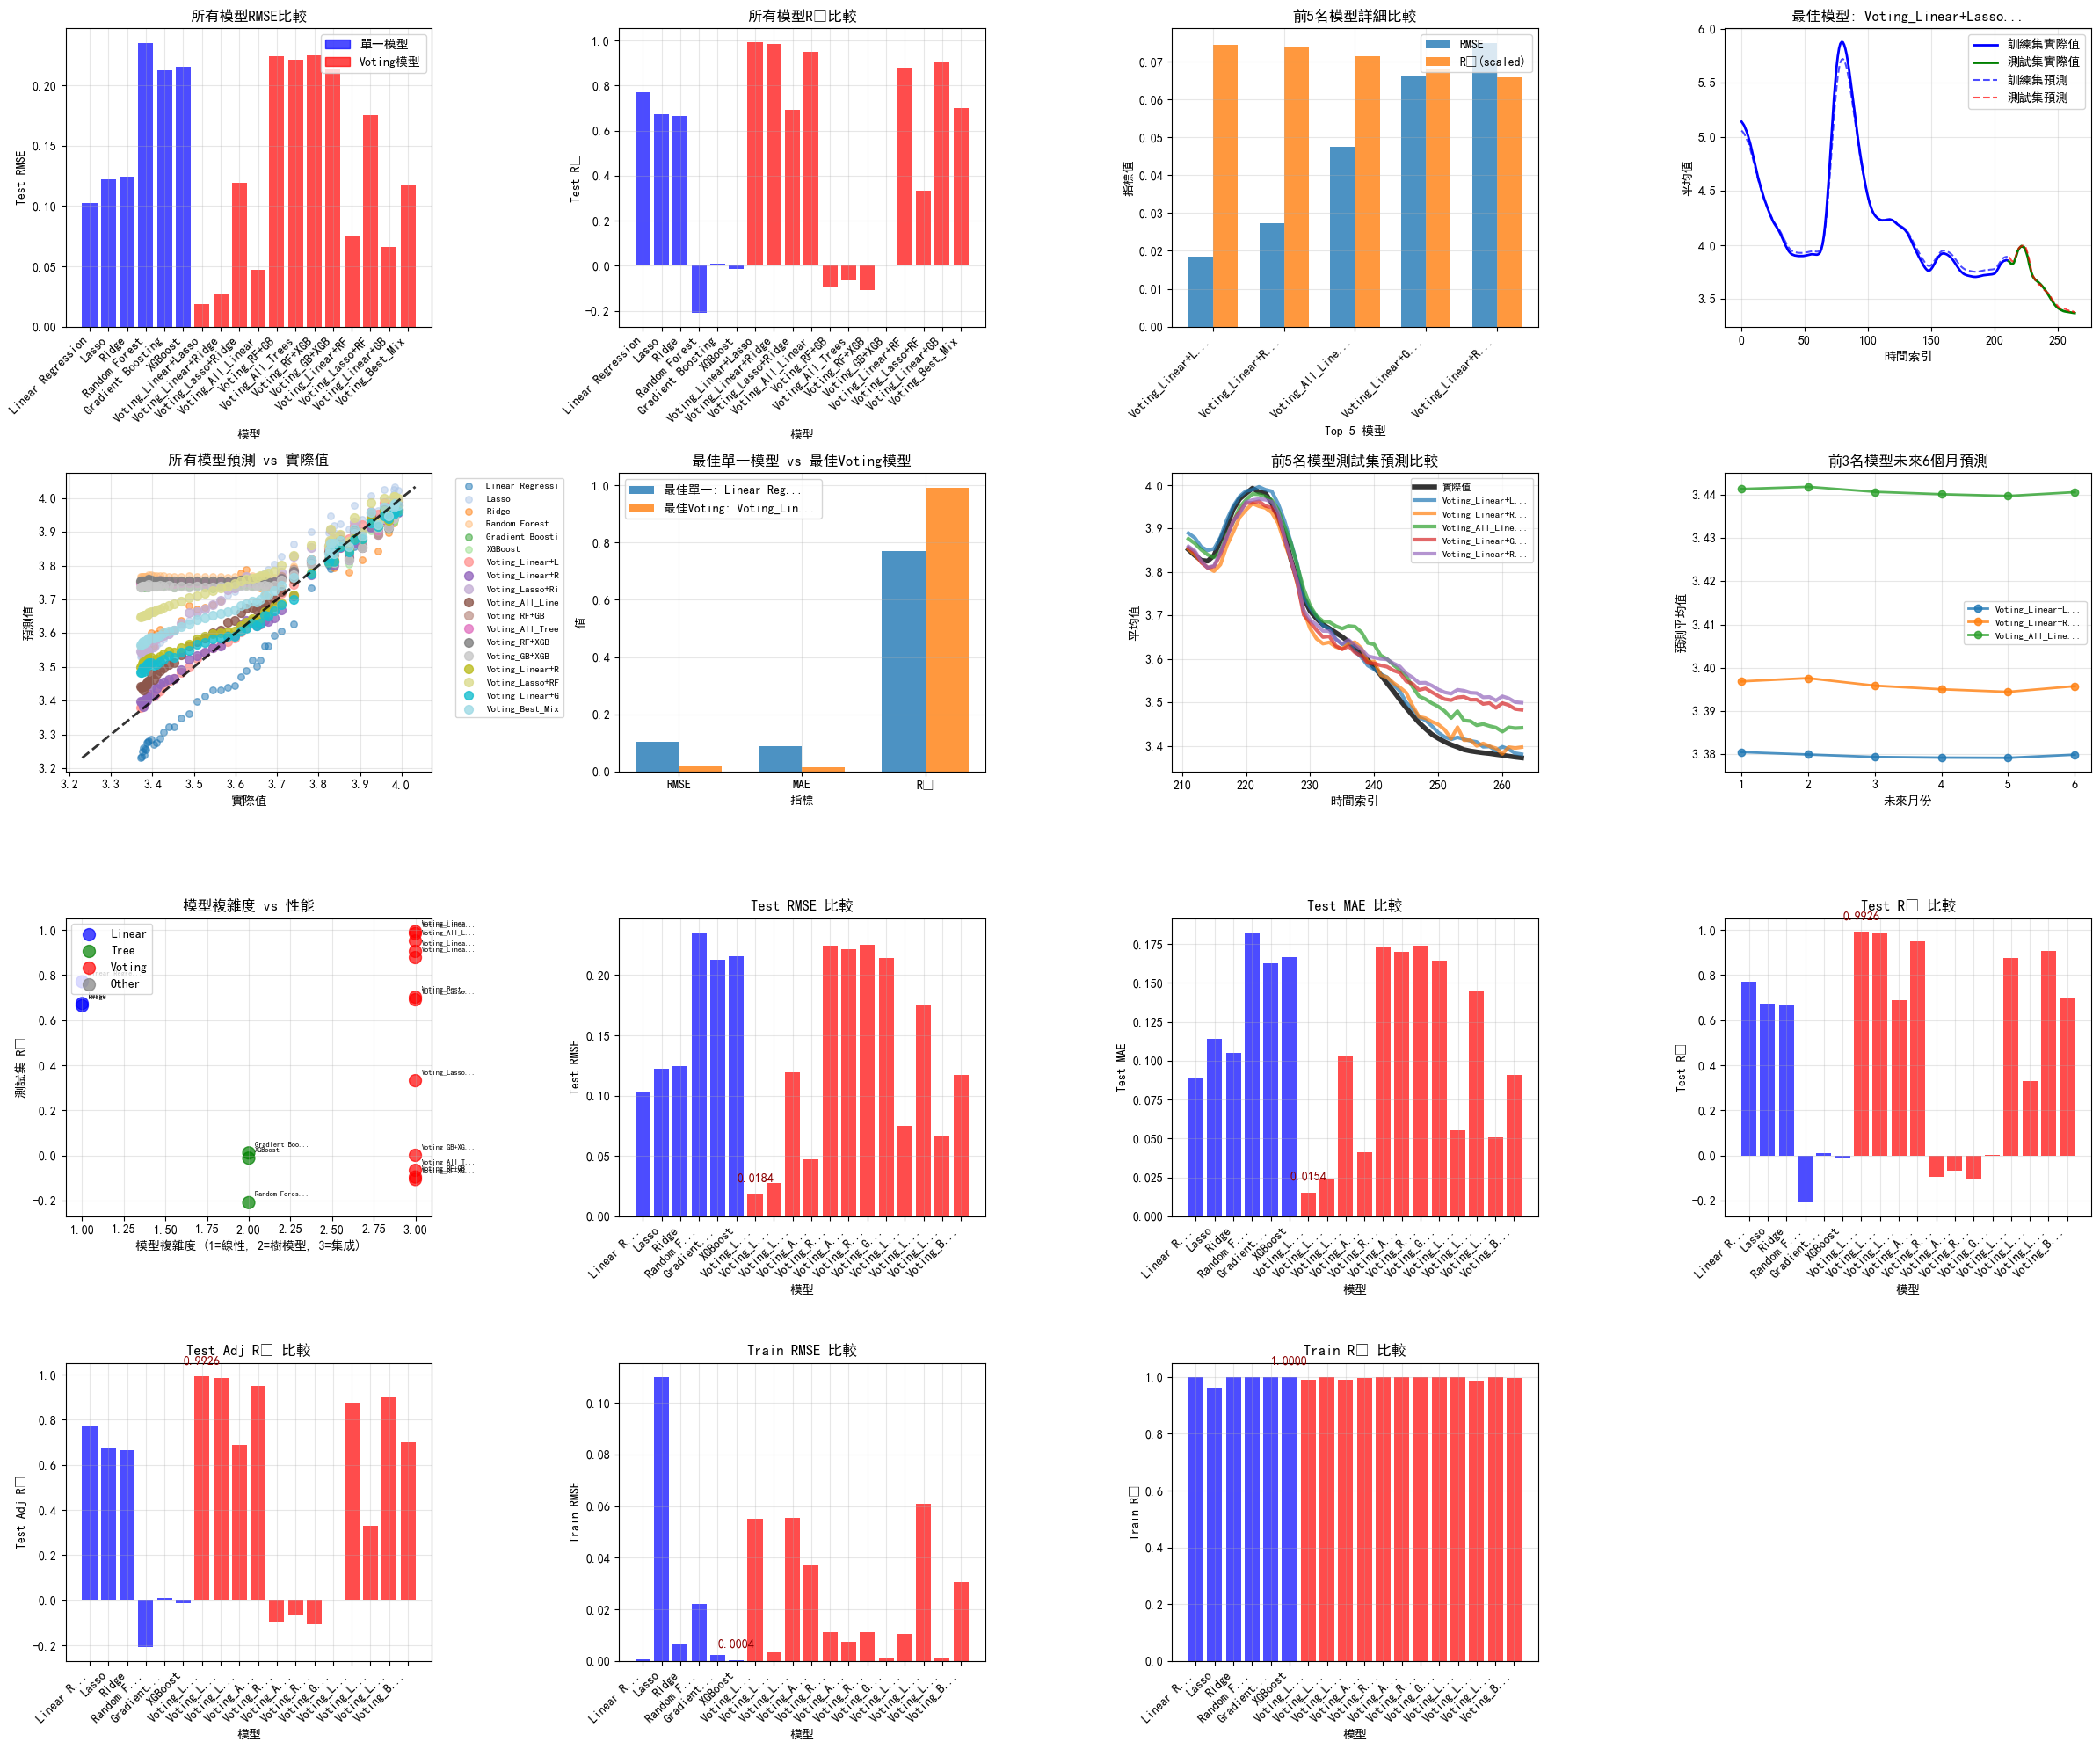


所有模型詳細性能統計:
模型名稱                      類型         Test RMSE    Test MAE     Test R²      Test Adj R² 
----------------------------------------------------------------------------------------------------
Voting_Linear+Lasso       Voting     0.018387     0.015388     0.992623     0.992623    
Voting_Linear+Ridge       Voting     0.027401     0.023529     0.983618     0.983618    
Voting_All_Linear         Voting     0.047436     0.040875     0.950904     0.950904    
Voting_Linear+GB          Voting     0.066024     0.050701     0.904887     0.904887    
Voting_Linear+RF          Voting     0.074974     0.055374     0.877353     0.877353    
Linear Regression         Single     0.102602     0.089150     0.770311     0.770311    
Voting_Best_Mix           Voting     0.116958     0.091039     0.701537     0.701537    
Voting_Lasso+Ridge        Voting     0.119165     0.102946     0.690166     0.690166    
Lasso                     Single     0.122313     0.114094     0.673579     0.673579 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
import csv
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 嘗試導入XGBoost和貝葉斯優化，如果沒有安裝則跳過
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("警告：XGBoost未安裝，將跳過XGBoost模型")

try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args
    from skopt.acquisition import gaussian_ei
    BAYESIAN_OPT_AVAILABLE = True
except ImportError:
    BAYESIAN_OPT_AVAILABLE = False
    print("警告：scikit-optimize未安裝，將跳過貝葉斯優化")

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 讀取Excel檔案
def load_data(file_path):
    """
    讀取失業率資料Excel檔案
    """
    df = pd.read_excel(file_path, sheet_name=0)
    return df

# 數據預處理
def preprocess_data(df):
    """
    數據預處理和特徵工程
    """
    data = df.copy()
    
    # 處理時間欄位
    if '統計期' in data.columns:
        def convert_roc_to_ad(roc_date):
            try:
                year_month = roc_date.replace('年', '-').replace('月', '')
                year, month = year_month.split('-')
                ad_year = int(year) + 1911
                return f"{ad_year}-{month.zfill(2)}"
            except:
                return None
        
        data['年月'] = data['統計期'].apply(convert_roc_to_ad)
        data['年月'] = pd.to_datetime(data['年月'], format='%Y-%m')
        data = data.sort_values('年月').reset_index(drop=True)
    
    # 處理缺失值
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data[numeric_columns] = data[numeric_columns].fillna(method='ffill')
    data[numeric_columns] = data[numeric_columns].fillna(method='bfill')
    
    # 移除非數值欄位
    feature_columns = [col for col in data.columns if col not in ['統計期', '年月', '平均']]
    feature_columns = [col for col in feature_columns if data[col].dtype in ['int64', 'float64']]
    
    return data, feature_columns

# 創建時間序列特徵（使用前一時間點預測下一時間點）
def create_time_series_features(data, target_col='平均', feature_cols=None):
    """
    創建時間序列特徵，使用t-1時間點的所有特徵預測t時間點的目標值
    """
    df = data.copy()
    
    if feature_cols is None:
        feature_cols = [col for col in df.columns 
                       if col not in ['統計期', '年月', target_col] and 
                       df[col].dtype in ['int64', 'float64']]
    
    # 創建滯後特徵（t-1時間點的所有特徵）
    lagged_features = []
    for col in feature_cols:
        df[f'{col}_lag1'] = df[col].shift(1)
        lagged_features.append(f'{col}_lag1')
    
    # 創建目標變數的滯後特徵
    for lag in [1, 2, 3, 6, 12]:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        lagged_features.append(f'{target_col}_lag_{lag}')
    
    # 創建移動平均特徵
    for window in [3, 6, 12]:
        df[f'{target_col}_ma_{window}'] = df[target_col].shift(1).rolling(window=window).mean()
        lagged_features.append(f'{target_col}_ma_{window}')
    
    # 創建趨勢特徵
    df[f'{target_col}_trend'] = df[target_col].shift(1).rolling(window=6).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 6 else np.nan
    )
    lagged_features.append(f'{target_col}_trend')
    
    # 創建季節性特徵
    if '年月' in df.columns:
        df['月份'] = df['年月'].dt.month
        df['季度'] = df['年月'].dt.quarter
        df['年份'] = df['年月'].dt.year
        df['月份_sin'] = np.sin(2 * np.pi * df['月份'] / 12)
        df['月份_cos'] = np.cos(2 * np.pi * df['月份'] / 12)
        lagged_features.extend(['月份', '季度', '月份_sin', '月份_cos'])
    
    # 移除包含NaN的行
    df_clean = df.dropna()
    
    return df_clean, lagged_features

# 貝葉斯優化參數調整
def bayesian_optimize_model(model_type, X_train, y_train, X_val, y_val, n_calls=50):
    """
    使用貝葉斯優化進行超參數調整
    """
    if not BAYESIAN_OPT_AVAILABLE:
        print(f"   跳過 {model_type} 的貝葉斯優化（scikit-optimize未安裝）")
        return None
    
    print(f"   開始 {model_type} 的貝葉斯優化...")
    
    # 定義搜索空間
    if model_type == 'Random Forest':
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 20, name='max_depth'),
            Integer(2, 20, name='min_samples_split'),
            Integer(1, 10, name='min_samples_leaf'),
            Real(0.1, 1.0, name='max_features')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = RandomForestRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    elif model_type == 'Gradient Boosting':
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 10, name='max_depth'),
            Real(0.01, 0.3, name='learning_rate'),
            Real(0.1, 1.0, name='subsample'),
            Integer(2, 20, name='min_samples_split'),
            Integer(1, 10, name='min_samples_leaf')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = GradientBoostingRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    elif model_type == 'XGBoost' and XGBOOST_AVAILABLE:
        dimensions = [
            Integer(50, 500, name='n_estimators'),
            Integer(3, 10, name='max_depth'),
            Real(0.01, 0.3, name='learning_rate'),
            Real(0.1, 1.0, name='subsample'),
            Real(0.1, 1.0, name='colsample_bytree'),
            Real(0, 10, name='reg_alpha'),
            Real(0, 10, name='reg_lambda')
        ]
        
        @use_named_args(dimensions)
        def objective(**params):
            model = xgb.XGBRegressor(
                random_state=42,
                **params
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return mean_squared_error(y_val, y_pred)
    
    else:
        return None
    
    # 執行貝葉斯優化
    try:
        result = gp_minimize(
            func=objective,
            dimensions=dimensions,
            n_calls=n_calls,
            random_state=42,
            acquisition_func=gaussian_ei
        )
        
        # 返回最佳參數
        best_params = {}
        for i, dim in enumerate(dimensions):
            best_params[dim.name] = result.x[i]
        
        print(f"   {model_type} 最佳參數: {best_params}")
        print(f"   最佳MSE: {result.fun:.6f}")
        
        return best_params
    
    except Exception as e:
        print(f"   {model_type} 貝葉斯優化失敗: {e}")
        return None

# 計算調整R²
def adjusted_r2_score(y_true, y_pred, n_features):
    """
    計算調整R²
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adjusted_r2

# 模型訓練和評估（包含貝葉斯優化）
def train_models_with_optimization(X_train, X_test, y_train, y_test, use_bayesian_opt=True):
    """
    訓練多個機器學習模型，包含貝葉斯優化
    """
    # 從訓練集中分出驗證集用於超參數優化
    if use_bayesian_opt and BAYESIAN_OPT_AVAILABLE:
        X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, shuffle=False
        )
        print(f"   優化用訓練集: {len(X_train_opt)}, 驗證集: {len(X_val_opt)}")
    else:
        X_train_opt, X_val_opt = X_train, None
        y_train_opt, y_val_opt = y_train, None
    
    # 基礎模型（不進行貝葉斯優化）
    base_models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(alpha=0.1, random_state=42),
        'Ridge': Ridge(alpha=1.0, random_state=42)
    }
    
    # 需要優化的樹模型
    tree_models = ['Random Forest', 'Gradient Boosting']
    if XGBOOST_AVAILABLE:
        tree_models.append('XGBoost')
    
    results = {}
    trained_models = {}
    scalers = {}
    best_params = {}
    
    # 訓練基礎模型
    for name, model in base_models.items():
        print(f"   訓練 {name}...")
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        scalers[name] = scaler
        
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
        # 計算指標
        results[name] = calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, X_train.shape[1])
        trained_models[name] = model
        best_params[name] = "No tuning needed"
    
    # 訓練樹模型（使用貝葉斯優化）
    for model_type in tree_models:
        print(f"   訓練 {model_type}...")
        scalers[model_type] = None
        
        # 貝葉斯優化
        if use_bayesian_opt and BAYESIAN_OPT_AVAILABLE and X_val_opt is not None:
            optimized_params = bayesian_optimize_model(
                model_type, X_train_opt, y_train_opt, X_val_opt, y_val_opt, n_calls=30
            )
        else:
            optimized_params = None
        
        # 創建模型
        if model_type == 'Random Forest':
            if optimized_params:
                model = RandomForestRegressor(random_state=42, **optimized_params)
            else:
                model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        elif model_type == 'Gradient Boosting':
            if optimized_params:
                model = GradientBoostingRegressor(random_state=42, **optimized_params)
            else:
                model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        
        elif model_type == 'XGBoost':
            if optimized_params:
                model = xgb.XGBRegressor(random_state=42, **optimized_params)
            else:
                model = xgb.XGBRegressor(n_estimators=100, random_state=42)
        
        # 訓練最終模型
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # 計算指標
        results[model_type] = calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, X_train.shape[1])
        trained_models[model_type] = model
        best_params[model_type] = optimized_params if optimized_params else "Default parameters"
    
    return results, trained_models, scalers, best_params

def calculate_metrics(y_train, y_train_pred, y_test, y_test_pred, n_features):
    """
    計算所有評估指標
    """
    # 訓練集指標
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 修正Adjusted R²計算，避免異常值
    n_train = len(y_train)
    if n_train > n_features + 1 and train_r2 >= 0:
        train_adj_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - n_features - 1)
        train_adj_r2 = max(0, min(1, train_adj_r2))  # 限制在[0,1]範圍內
    else:
        train_adj_r2 = train_r2
    
    # 測試集指標
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 修正Adjusted R²計算
    n_test = len(y_test)
    if n_test > n_features + 1 and test_r2 >= 0:
        test_adj_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - n_features - 1)
        test_adj_r2 = max(0, min(1, test_adj_r2))  # 限制在[0,1]範圍內
    else:
        test_adj_r2 = test_r2
    
    return {
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'train_adj_r2': train_adj_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_adj_r2': test_adj_r2,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred
    }

# 創建多種Voting集成模型
def create_multiple_voting_models(X_train, X_test, y_train, y_test, trained_models, scalers):
    """
    創建多種不同組合的Voting集成模型
    """
    print("   創建多種Voting集成模型...")
    
    voting_results = {}
    voting_models = {}
    voting_scalers = {}
    
    # 定義不同的Voting組合
    voting_combinations = {
        'Voting_Linear+Lasso': ['Linear Regression', 'Lasso'],
        'Voting_Linear+Ridge': ['Linear Regression', 'Ridge'],
        'Voting_Lasso+Ridge': ['Lasso', 'Ridge'],
        'Voting_All_Linear': ['Linear Regression', 'Lasso', 'Ridge'],
    }
    
    # 如果有樹模型，添加樹模型組合
    tree_models = []
    for model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
        if model_name in trained_models:
            tree_models.append(model_name)
    
    if len(tree_models) >= 2:
        voting_combinations['Voting_RF+GB'] = ['Random Forest', 'Gradient Boosting']
        if 'XGBoost' in tree_models:
            voting_combinations['Voting_All_Trees'] = tree_models
            voting_combinations['Voting_RF+XGB'] = ['Random Forest', 'XGBoost']
            voting_combinations['Voting_GB+XGB'] = ['Gradient Boosting', 'XGBoost']
    
    # 混合線性和樹模型的組合
    if tree_models:
        voting_combinations['Voting_Linear+RF'] = ['Linear Regression', 'Random Forest']
        voting_combinations['Voting_Lasso+RF'] = ['Lasso', 'Random Forest']
        if 'Gradient Boosting' in tree_models:
            voting_combinations['Voting_Linear+GB'] = ['Linear Regression', 'Gradient Boosting']
        
        # 最佳混合組合
        if len(tree_models) >= 2:
            voting_combinations['Voting_Best_Mix'] = ['Linear Regression', 'Lasso', 'Random Forest', 'Gradient Boosting']
    
    # 創建每個Voting模型
    for voting_name, model_names in voting_combinations.items():
        try:
            print(f"     創建 {voting_name}: {' + '.join(model_names)}")
            
            # 檢查是否所有需要的模型都存在
            if not all(name in trained_models for name in model_names):
                print(f"       跳過 {voting_name} - 缺少必需的基礎模型")
                continue
            
            # 準備估計器列表
            estimators = []
            need_scaling = False
            
            for model_name in model_names:
                if model_name in ['Linear Regression', 'Lasso', 'Ridge']:
                    need_scaling = True
                estimators.append((model_name.lower().replace(' ', '_'), trained_models[model_name]))
            
            # 處理數據縮放
            if need_scaling:
                # 對於包含線性模型的組合，需要縮放
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                voting_scalers[voting_name] = scaler
                
                # 重新訓練線性模型（在縮放後的數據上）
                updated_estimators = []
                for name, model in estimators:
                    if any(linear_name.lower().replace(' ', '_') == name for linear_name in ['Linear Regression', 'Lasso', 'Ridge']):
                        # 重新訓練線性模型
                        model_copy = type(model)(**model.get_params())
                        model_copy.fit(X_train_scaled, y_train)
                        updated_estimators.append((name, model_copy))
                    else:
                        updated_estimators.append((name, model))
                estimators = updated_estimators
                
                X_train_for_voting = X_train_scaled
                X_test_for_voting = X_test_scaled
            else:
                # 純樹模型組合，不需要縮放
                voting_scalers[voting_name] = None
                X_train_for_voting = X_train
                X_test_for_voting = X_test
            
            # 創建Voting模型
            voting_model = VotingRegressor(estimators=estimators)
            
            # 訓練Voting模型
            voting_model.fit(X_train_for_voting, y_train)
            
            # 預測
            y_train_pred_voting = voting_model.predict(X_train_for_voting)
            y_test_pred_voting = voting_model.predict(X_test_for_voting)
            
            # 計算指標
            voting_metrics = calculate_metrics(y_train, y_train_pred_voting, y_test, y_test_pred_voting, X_train.shape[1])
            
            # 保存結果
            voting_results[voting_name] = voting_metrics
            voting_models[voting_name] = voting_model
            
            print(f"       {voting_name} 性能 - Train RMSE: {voting_metrics['train_rmse']:.4f}, Test RMSE: {voting_metrics['test_rmse']:.4f}, Test R²: {voting_metrics['test_r2']:.4f}")
            
        except Exception as e:
            print(f"       錯誤：創建 {voting_name} 失敗 - {e}")
            continue
    
    return voting_results, voting_models, voting_scalers

# 預測未來值（改進版，確保合理的預測結果）
def predict_future_improved(model, scaler, data, feature_cols, target_col='平均', months_ahead=6, model_name='Random Forest'):
    """
    使用改進的滾動預測方法預測未來值，確保預測結果在合理範圍內
    """
    predictions = []
    df_copy = data.copy()
    
    # 獲取歷史目標值的統計信息，用於約束預測結果
    historical_values = df_copy[target_col].values
    min_historical = historical_values.min()
    max_historical = historical_values.max()
    mean_historical = historical_values.mean()
    std_historical = historical_values.std()
    
    print(f"   歷史數據範圍: [{min_historical:.4f}, {max_historical:.4f}]")
    print(f"   歷史數據均值: {mean_historical:.4f}, 標準差: {std_historical:.4f}")
    
    for i in range(months_ahead):
        try:
            # 使用最近的數據作為特徵
            recent_data = df_copy.tail(1).copy()
            
            # 構建特徵向量 - 使用更簡單的方法
            if len(feature_cols) > 0:
                # 使用最後一行的所有特徵
                X_latest = recent_data[feature_cols].values.reshape(1, -1)
                
                # 處理NaN值
                X_latest = np.nan_to_num(X_latest, nan=mean_historical)
                
                # 進行預測
                if 'Linear' in model_name or 'Lasso' in model_name or 'Ridge' in model_name:
                    if scaler is not None:
                        # 確保特徵維度匹配
                        if X_latest.shape[1] != scaler.n_features_in_:
                            # 調整維度
                            if X_latest.shape[1] > scaler.n_features_in_:
                                X_latest = X_latest[:, :scaler.n_features_in_]
                            else:
                                # 用均值填充
                                padding = np.full((1, scaler.n_features_in_ - X_latest.shape[1]), mean_historical)
                                X_latest = np.concatenate([X_latest, padding], axis=1)
                        
                        X_scaled = scaler.transform(X_latest)
                        pred = model.predict(X_scaled)[0]
                    else:
                        pred = model.predict(X_latest)[0]
                else:
                    pred = model.predict(X_latest)[0]
                
                # 約束預測結果在合理範圍內
                # 使用最近趨勢和歷史範圍來約束
                recent_trend = historical_values[-6:].mean() if len(historical_values) >= 6 else mean_historical
                
                # 限制預測值不要偏離歷史範圍太遠
                lower_bound = min(min_historical, recent_trend - 2 * std_historical)
                upper_bound = max(max_historical, recent_trend + 2 * std_historical)
                
                pred = np.clip(pred, lower_bound, upper_bound)
                
            else:
                # 如果沒有特徵，使用簡單的趨勢預測
                if len(historical_values) >= 3:
                    pred = np.mean(historical_values[-3:])
                else:
                    pred = mean_historical
            
            predictions.append(pred)
            
            # 更新數據框
            new_row = recent_data.copy()
            new_row[target_col] = pred
            
            # 更新時間相關特徵
            if '月份' in new_row.columns:
                current_month = new_row['月份'].iloc[0]
                next_month = (current_month % 12) + 1
                new_row['月份'] = next_month
                new_row['季度'] = ((next_month - 1) // 3) + 1
                if '月份_sin' in new_row.columns:
                    new_row['月份_sin'] = np.sin(2 * np.pi * next_month / 12)
                if '月份_cos' in new_row.columns:
                    new_row['月份_cos'] = np.cos(2 * np.pi * next_month / 12)
            
            df_copy = pd.concat([df_copy, new_row], ignore_index=True)
            
        except Exception as e:
            print(f"   預測第{i+1}個月時發生錯誤: {e}")
            # 使用簡單的備用預測
            if len(predictions) > 0:
                pred = predictions[-1]  # 使用上一個預測值
            else:
                pred = mean_historical  # 使用歷史均值
            predictions.append(pred)
    
    return predictions

# 綜合繪製所有模型（單一模型 + 多種Voting模型）
def plot_comprehensive_model_comparison(data, single_results, voting_results, X_train, X_test, y_train, y_test, 
                                      single_models, voting_models, single_scalers, voting_scalers, feature_cols):
    """
    綜合比較所有模型（單一模型和多種Voting模型）
    """
    # 合併所有結果
    all_results = {**single_results, **voting_results}
    all_models = {**single_models, **voting_models}
    all_scalers = {**single_scalers, **voting_scalers}
    
    # 創建大圖
    plt.figure(figsize=(24, 20))
    
    # 1. 模型性能比較 - RMSE
    plt.subplot(4, 4, 1)
    model_names = list(all_results.keys())
    test_rmse = [all_results[model]['test_rmse'] for model in model_names]
    
    # 區分單一模型和Voting模型的顏色
    colors = []
    for name in model_names:
        if 'Voting' in name:
            colors.append('red')
        else:
            colors.append('blue')
    
    bars = plt.bar(range(len(model_names)), test_rmse, color=colors, alpha=0.7)
    plt.xlabel('模型')
    plt.ylabel('Test RMSE')
    plt.title('所有模型RMSE比較')
    plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # 添加圖例
    plt.legend([plt.Rectangle((0,0),1,1, color='blue', alpha=0.7),
                plt.Rectangle((0,0),1,1, color='red', alpha=0.7)],
               ['單一模型', 'Voting模型'], loc='upper right')
    
    # 2. 模型性能比較 - R²
    plt.subplot(4, 4, 2)
    test_r2 = [all_results[model]['test_r2'] for model in model_names]
    
    bars = plt.bar(range(len(model_names)), test_r2, color=colors, alpha=0.7)
    plt.xlabel('模型')
    plt.ylabel('Test R²')
    plt.title('所有模型R²比較')
    plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # 3. 前5名模型詳細比較
    plt.subplot(4, 4, 3)
    # 按Test RMSE排序，取前5名
    sorted_models = sorted(all_results.items(), key=lambda x: x[1]['test_rmse'])[:5]
    top5_names = [item[0] for item in sorted_models]
    top5_rmse = [item[1]['test_rmse'] for item in sorted_models]
    top5_r2 = [item[1]['test_r2'] for item in sorted_models]
    
    x = np.arange(len(top5_names))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, top5_rmse, width, label='RMSE', alpha=0.8)
    bars2 = plt.bar(x + width/2, [r2*max(top5_rmse) for r2 in top5_r2], width, 
                    label='R²(scaled)', alpha=0.8)
    
    plt.xlabel('Top 5 模型')
    plt.ylabel('指標值')
    plt.title('前5名模型詳細比較')
    plt.xticks(x, [name[:15] + '...' if len(name) > 15 else name for name in top5_names], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 時間序列預測結果（最佳模型）
    plt.subplot(4, 4, 4)
    best_model_name = sorted_models[0][0]
    best_model = all_models[best_model_name]
    best_scaler = all_scalers[best_model_name]
    
    train_size = len(X_train)
    test_size = len(X_test)
    train_indices = range(train_size)
    test_indices = range(train_size, train_size + test_size)
    
    plt.plot(train_indices, y_train, 'b-', label='訓練集實際值', linewidth=2)
    plt.plot(test_indices, y_test, 'g-', label='測試集實際值', linewidth=2)
    plt.plot(train_indices, all_results[best_model_name]['train_predictions'], 'b--', 
             label=f'訓練集預測', alpha=0.7)
    plt.plot(test_indices, all_results[best_model_name]['test_predictions'], 'r--', 
             label=f'測試集預測', alpha=0.7)
    
    plt.title(f'最佳模型: {best_model_name[:20]}...')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. 所有模型預測vs實際值散點圖
    plt.subplot(4, 4, 5)
    colors_scatter = plt.cm.tab20(np.linspace(0, 1, len(model_names)))
    
    for i, model_name in enumerate(model_names):
        test_pred = all_results[model_name]['test_predictions']
        alpha = 0.8 if 'Voting' in model_name else 0.5
        size = 50 if 'Voting' in model_name else 30
        plt.scatter(y_test, test_pred, alpha=alpha, label=model_name[:15], 
                   color=colors_scatter[i], s=size)
    
    # 完美預測線
    min_val = min(y_test.min(), min([all_results[model]['test_predictions'].min() for model in model_names]))
    max_val = max(y_test.max(), max([all_results[model]['test_predictions'].max() for model in model_names]))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, alpha=0.8)
    
    plt.xlabel('實際值')
    plt.ylabel('預測值')
    plt.title('所有模型預測 vs 實際值')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 6. Voting模型 vs 最佳單一模型比較
    plt.subplot(4, 4, 6)
    # 找出最佳單一模型和最佳Voting模型
    single_model_results = {k: v for k, v in all_results.items() if 'Voting' not in k}
    voting_model_results = {k: v for k, v in all_results.items() if 'Voting' in k}
    
    if single_model_results and voting_model_results:
        best_single = min(single_model_results.items(), key=lambda x: x[1]['test_rmse'])
        best_voting = min(voting_model_results.items(), key=lambda x: x[1]['test_rmse'])
        
        categories = ['RMSE', 'MAE', 'R²']
        single_values = [best_single[1]['test_rmse'], best_single[1]['test_mae'], best_single[1]['test_r2']]
        voting_values = [best_voting[1]['test_rmse'], best_voting[1]['test_mae'], best_voting[1]['test_r2']]
        
        x = np.arange(len(categories))
        width = 0.35
        
        plt.bar(x - width/2, single_values, width, label=f'最佳單一: {best_single[0][:10]}...', alpha=0.8)
        plt.bar(x + width/2, voting_values, width, label=f'最佳Voting: {best_voting[0][:10]}...', alpha=0.8)
        
        plt.xlabel('指標')
        plt.ylabel('值')
        plt.title('最佳單一模型 vs 最佳Voting模型')
        plt.xticks(x, categories)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 7. 所有模型測試集時間序列比較
    plt.subplot(4, 4, 7)
    plt.plot(test_indices, y_test, 'k-', label='實際值', linewidth=4, alpha=0.8)
    
    # 只顯示前5名模型避免圖表太亂
    for i, (model_name, _) in enumerate(sorted_models[:5]):
        test_pred = all_results[model_name]['test_predictions']
        linestyle = '-' if 'Voting' in model_name else '--'
        linewidth = 3 if 'Voting' in model_name else 2
        plt.plot(test_indices, test_pred, linestyle, alpha=0.7, 
                label=f'{model_name[:15]}...', linewidth=linewidth)
    
    plt.title('前5名模型測試集預測比較')
    plt.xlabel('時間索引')
    plt.ylabel('平均值')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 8. 未來預測比較（前3名模型）
    plt.subplot(4, 4, 8)
    future_predictions = {}
    
    for model_name, _ in sorted_models[:3]:
        try:
            model = all_models[model_name]
            scaler = all_scalers[model_name]
            future_pred = predict_future_improved(
                model, scaler, data, feature_cols,
                target_col='平均', months_ahead=6, model_name=model_name
            )
            future_predictions[model_name] = future_pred
        except Exception as e:
            print(f"未來預測失敗 {model_name}: {e}")
            continue
    
    if future_predictions:
        future_months = range(1, 7)
        for model_name, preds in future_predictions.items():
            linestyle = '-' if 'Voting' in model_name else '--'
            marker = 'o' if 'Voting' in model_name else '^'
            plt.plot(future_months, preds, linestyle, marker=marker, linewidth=2, 
                    markersize=6, label=f'{model_name[:15]}...', alpha=0.8)
        
        plt.title('前3名模型未來6個月預測')
        plt.xlabel('未來月份')
        plt.ylabel('預測平均值')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
        plt.xticks(future_months)
    
    # 9. 模型複雜度分析
    plt.subplot(4, 4, 9)
    model_types = []
    performance_scores = []
    complexity_scores = []
    
    for model_name in model_names:
        performance_scores.append(all_results[model_name]['test_r2'])
        
        # 模型類型分類
        if 'Voting' in model_name:
            model_types.append('Voting')
            complexity_scores.append(3)  # Voting模型複雜度中等
        elif model_name in ['Linear Regression', 'Lasso', 'Ridge']:
            model_types.append('Linear')
            complexity_scores.append(1)
        elif model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
            model_types.append('Tree')
            complexity_scores.append(2)
        else:
            model_types.append('Other')
            complexity_scores.append(2)
    
    type_colors = {'Linear': 'blue', 'Tree': 'green', 'Voting': 'red', 'Other': 'gray'}
    colors_complex = [type_colors[t] for t in model_types]
    
    scatter = plt.scatter(complexity_scores, performance_scores, c=colors_complex, s=100, alpha=0.7)
    
    for i, model_name in enumerate(model_names):
        if len(model_name) > 12:
            label = model_name[:12] + '...'
        else:
            label = model_name
        plt.annotate(label, (complexity_scores[i], performance_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=6)
    
    plt.xlabel('模型複雜度 (1=線性, 2=樹模型, 3=集成)')
    plt.ylabel('測試集 R²')
    plt.title('模型複雜度 vs 性能')
    plt.grid(True, alpha=0.3)
    
    # 添加圖例
    legend_elements = [plt.scatter([], [], c=color, s=100, alpha=0.7, label=type_name)
                      for type_name, color in type_colors.items()]
    plt.legend(handles=legend_elements, loc='upper left')
    
    # 10-16. 詳細性能指標比較
    metrics = ['test_rmse', 'test_mae', 'test_r2', 'test_adj_r2', 'train_rmse', 'train_r2']
    metric_titles = ['Test RMSE', 'Test MAE', 'Test R²', 'Test Adj R²', 'Train RMSE', 'Train R²']
    
    for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
        plt.subplot(4, 4, 10 + i)
        
        values = [all_results[model][metric] for model in model_names]
        colors_metric = ['red' if 'Voting' in name else 'blue' for name in model_names]
        
        bars = plt.bar(range(len(model_names)), values, color=colors_metric, alpha=0.7)
        plt.xlabel('模型')
        plt.ylabel(title)
        plt.title(f'{title} 比較')
        plt.xticks(range(len(model_names)), 
                  [name[:8] + '...' if len(name) > 8 else name for name in model_names], 
                  rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # 標註最佳值
        if 'rmse' in metric or 'mae' in metric:
            best_idx = np.argmin(values)
        else:
            best_idx = np.argmax(values)
        
        plt.annotate(f'{values[best_idx]:.4f}', 
                    (best_idx, values[best_idx]), 
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', fontweight='bold', color='darkred')
    
    plt.tight_layout()
    plt.show()
    
    # 打印詳細統計信息
    print("\n" + "="*100)
    print("所有模型詳細性能統計:")
    print("="*100)
    print(f"{'模型名稱':<25} {'類型':<10} {'Test RMSE':<12} {'Test MAE':<12} {'Test R²':<12} {'Test Adj R²':<12}")
    print("-"*100)
    
    for model_name in sorted(all_results.keys(), key=lambda x: all_results[x]['test_rmse']):
        model_type = 'Voting' if 'Voting' in model_name else 'Single'
        metrics = all_results[model_name]
        print(f"{model_name:<25} {model_type:<10} {metrics['test_rmse']:<12.6f} {metrics['test_mae']:<12.6f} "
              f"{metrics['test_r2']:<12.6f} {metrics['test_adj_r2']:<12.6f}")
    
    print("\n" + "="*50)
    print("最佳模型總結:")
    print("="*50)
    print(f"最佳整體模型: {sorted_models[0][0]}")
    print(f"最佳Test RMSE: {sorted_models[0][1]['test_rmse']:.6f}")
    print(f"最佳Test R²: {sorted_models[0][1]['test_r2']:.6f}")
    
    if voting_model_results:
        best_voting = min(voting_model_results.items(), key=lambda x: x[1]['test_rmse'])
        print(f"\n最佳Voting模型: {best_voting[0]}")
        print(f"Voting Test RMSE: {best_voting[1]['test_rmse']:.6f}")
        print(f"Voting Test R²: {best_voting[1]['test_r2']:.6f}")
    
    return all_results, future_predictions

# 主函數
def main(file_path='失業率資料_2.xlsx'):
    """
    主函數：執行完整的預測流程，包含多種Voting模型
    """
    print("=== 增強版失業率預測系統（多種Voting模型） ===\n")
    
    # 1. 讀取數據
    print("1. 讀取數據...")
    try:
        df = load_data(file_path)
        print(f"   數據載入成功，共 {len(df)} 行 {len(df.columns)} 列")
    except Exception as e:
        print(f"   錯誤：無法讀取檔案 - {e}")
        return
    
    # 2. 數據預處理
    print("\n2. 數據預處理...")
    try:
        processed_data, original_feature_columns = preprocess_data(df)
        print(f"   預處理完成，原始特徵數量：{len(original_feature_columns)}")
    except Exception as e:
        print(f"   錯誤：數據預處理失敗 - {e}")
        return
    
    # 3. 時間序列特徵工程
    print("\n3. 時間序列特徵工程...")
    try:
        enhanced_data, feature_columns = create_time_series_features(
            processed_data, target_col='平均', feature_cols=original_feature_columns
        )
        print(f"   特徵工程完成，最終特徵數量：{len(feature_columns)}")
        print(f"   數據行數：{len(enhanced_data)}")
    except Exception as e:
        print(f"   錯誤：特徵工程失敗 - {e}")
        return
    
    # 4. 準備訓練數據
    print("\n4. 準備訓練數據...")
    try:
        X = enhanced_data[feature_columns]
        y = enhanced_data['平均']
        
        # 時間序列分割：前80%作為訓練集，後20%作為測試集
        split_idx = int(len(X) * 0.8)
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]
        
        print(f"   訓練集大小：{len(X_train)}")
        print(f"   測試集大小：{len(X_test)}")
        print(f"   特徵數量：{len(feature_columns)}")
    except Exception as e:
        print(f"   錯誤：數據準備失敗 - {e}")
        return
    
    # 5. 訓練單一模型
    print("\n5. 訓練單一模型...")
    try:
        single_results, single_models, single_scalers, best_params = train_models_with_optimization(
            X_train, X_test, y_train, y_test, use_bayesian_opt=True
        )
        print(f"   單一模型訓練完成，共訓練了 {len(single_results)} 個模型")
    except Exception as e:
        print(f"   錯誤：單一模型訓練失敗 - {e}")
        return
    
    # 6. 創建多種Voting模型
    print("\n6. 創建多種Voting模型...")
    try:
        voting_results, voting_models, voting_scalers = create_multiple_voting_models(
            X_train, X_test, y_train, y_test, single_models, single_scalers
        )
        print(f"   Voting模型創建完成，共創建了 {len(voting_results)} 個Voting模型")
    except Exception as e:
        print(f"   錯誤：Voting模型創建失敗 - {e}")
        voting_results, voting_models, voting_scalers = {}, {}, {}
    
    # 7. 綜合比較所有模型
    print("\n7. 綜合比較所有模型...")
    try:
        all_results, future_predictions = plot_comprehensive_model_comparison(
            enhanced_data, single_results, voting_results, X_train, X_test, y_train, y_test,
            single_models, voting_models, single_scalers, voting_scalers, feature_columns
        )
        print("   綜合比較圖表生成完成")
    except Exception as e:
        print(f"   警告：綜合比較失敗 - {e}")
        import traceback
        traceback.print_exc()
    
    print("\n=== 預測完成 ===")
    
    return {
        'single_results': single_results,
        'voting_results': voting_results,
        'all_results': all_results,
        'single_models': single_models,
        'voting_models': voting_models,
        'future_predictions': future_predictions,
        'enhanced_data': enhanced_data,
        'feature_columns': feature_columns
    }

# 執行預測
if __name__ == "__main__":
    # 安裝所需套件的提示
    print("請確保已安裝以下套件：")
    print("pip install pandas numpy scikit-learn matplotlib seaborn openpyxl")
    
    if XGBOOST_AVAILABLE:
        print("XGBoost 已安裝")
    else:
        print("如需使用XGBoost，請執行：pip install xgboost")
    
    if BAYESIAN_OPT_AVAILABLE:
        print("scikit-optimize 已安裝，將使用貝葉斯優化")
    else:
        print("如需使用貝葉斯優化，請執行：pip install scikit-optimize")
    
    print("\n" + "="*80 + "\n")
    
    prediction_results = main('失業率資料_2.xlsx')